In [2]:
import numpy as np
import nest
import matplotlib.pyplot as plt
from matplotlib import rcParams 
import unicodeit


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.3
 Built: May  5 2022 07:35:57

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [3]:
nest.set_verbosity('M_ERROR') 

# Single PSP sum

In [4]:
def simulate_mso(delta_inh, taus, we, w_ratio, i_ext, tone, time_sim):
    
    nest.ResetKernel()
    nest.local_num_threads = 16
    nest.resolution = 0.01 
    
    wi = -we*w_ratio
    delays_mso = [5,5+delta_inh] #ms
    weights_mso = [we,wi]
    #c_mso = 1
    
    ipsi_e = nest.Create("spike_generator", 1, params={"spike_times": np.around(np.arange(1, time_sim+1, 1000/tone),2)})

    mso = nest.Create('iaf_cond_beta', 2)

    for i in range(2):
        mso[i].set(V_th = v_th, C_m = c_mso, tau_rise_ex = taus[0], tau_rise_in = taus[1], tau_decay_ex = taus[2], tau_decay_in = taus[3], I_e = i_ext)

    m = nest.Create('multimeter', 1, {"record_from": ['V_m']})
    nest.SetStatus(m, {'interval': 0.01})

    nest.Connect(m, mso, 'all_to_all')

    nest.Connect(ipsi_e, mso[0], 'one_to_one', syn_spec = {"weight":weights_mso[0], "delay": delays_mso[0]})
    nest.Connect(ipsi_e, mso[1], 'one_to_one', syn_spec = {"weight":weights_mso[0], "delay": delays_mso[0]})
    nest.Connect(ipsi_e, mso[1], 'one_to_one', syn_spec = {"weight":weights_mso[1], "delay": delays_mso[1]})
    
    nest.Simulate(time_sim)
    
    pot = m.get('events')
    
    t_both = pot['times'][np.where(pot['V_m'] == np.max(pot['V_m'][np.where((pot['senders'] == mso[1]) & (pot['times'] < 5 + 1000/tone + 1))]))][0]
    t_exc = pot['times'][np.where(pot['V_m'] == np.max(pot['V_m'][np.where((pot['senders'] == mso[0]) & (pot['times'] < 5 + 1000/tone + 1))]))][0]
    peak_shift = (t_both - t_exc)*1000
    
    return(peak_shift)

delta_t =  -0.4 ms
peak_shift =  10.0 μs  (peak delay)


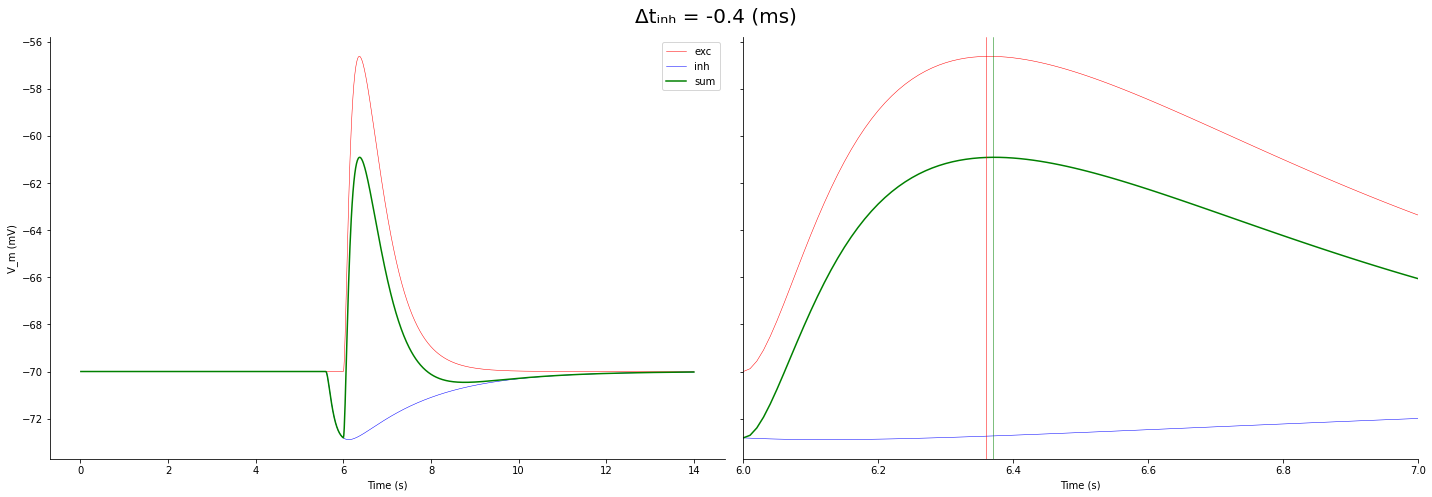

In [5]:
tone = 100
time_sim = 15
lim = time_sim
delta_inh = -0.4

taus = np.zeros(4)
taus[:] =  [0.2, 0.2, 0.5, 1.5] #default: [0.2, 2, 0.2, 2] #avgMyoga[x,x,0.3,1.5]  #bestMyoga[x,x,0.5,1]
w_ratio = 1
we = 4

c_mso = 1
wi = -we*w_ratio
delays_mso = [5,5+delta_inh] #ms
weights_mso = [we,wi]
v_th = -40
i_ext = 0

nest.ResetKernel()
nest.local_num_threads = 16
nest.resolution = 0.01 

ipsi_e = nest.Create("spike_generator", 1, params={"spike_times": np.around(np.arange(1, time_sim+1, 1000/tone),2)})

mso = nest.Create('iaf_cond_beta', 3)

for i in range(3):
    mso[i].set(V_th = v_th, C_m = c_mso, tau_rise_ex = taus[0], tau_rise_in = taus[1], tau_decay_ex = taus[2], tau_decay_in = taus[3], I_e = i_ext)

s = nest.Create('spike_recorder')

m = nest.Create('multimeter', 1, {"record_from": ['V_m']})
nest.SetStatus(m, {'interval': 0.01})

nest.Connect(mso, s, 'all_to_all')
nest.Connect(ipsi_e, s, 'one_to_one')
nest.Connect(m, mso, 'all_to_all')
nest.Connect(ipsi_e, mso[0], 'one_to_one', syn_spec = {"weight":weights_mso[0], "delay": delays_mso[0]})
nest.Connect(ipsi_e, mso[1], 'one_to_one', syn_spec = {"weight":weights_mso[1], "delay": delays_mso[1]})
nest.Connect(ipsi_e, mso[2], 'one_to_one', syn_spec = {"weight":weights_mso[0], "delay": delays_mso[0]})
nest.Connect(ipsi_e, mso[2], 'one_to_one', syn_spec = {"weight":weights_mso[1], "delay": delays_mso[1]})

nest.Simulate(time_sim)
#data = s.get('events')
pot = m.get('events')


t_both = pot['times'][max(range(len(pot['V_m'][np.where(pot['senders'] == mso[2])])), key=pot['V_m'][np.where(pot['senders'] == mso[2])].__getitem__)]
t_exc = pot['times'][max(range(len(pot['V_m'][np.where(pot['senders'] == mso[0])])), key=pot['V_m'][np.where(pot['senders'] == mso[0])].__getitem__)]
peak_shift = (t_both - t_exc)*1000
peak_shift = round(peak_shift,4)
if(peak_shift>0):
    msg = '(peak delay)'
elif(peak_shift<0):
    msg = '(peak advance)'
else:
    msg = '(no shift)'
print('delta_t = ', delta_inh, 'ms')
print('peak_shift = ', peak_shift, 'μs ', msg)

fig, ax = plt.subplots(1,2, figsize=(20,7), sharey = True)
for i in range(2):
    ax[i].plot(pot['times'][np.where(pot['senders'] == mso[0].get('global_id'))], pot['V_m'][np.where(pot['senders'] == mso[0].get('global_id'))], color = 'r', linewidth = 0.5, label = 'exc')
    ax[i].plot(pot['times'][np.where(pot['senders'] == mso[1].get('global_id'))], pot['V_m'][np.where(pot['senders'] == mso[1].get('global_id'))], color = 'b', linewidth = 0.5, label = 'inh')
    ax[i].plot(pot['times'][np.where(pot['senders'] == mso[2].get('global_id'))], pot['V_m'][np.where(pot['senders'] == mso[2].get('global_id'))], color = 'g', label = 'sum')
    ax[i].spines['top'].set_visible(False) 
    ax[i].spines['right'].set_visible(False)
    ax[i].set_xlabel('Time (s)')

ax[0].legend()
ax[0].set_ylabel('V_m (mV)')
ax[1].set_xlim([6,7])
ax[1].axvline(t_both, color = 'g', linewidth = 0.5)
ax[1].axvline(t_exc, color = 'r', linewidth = 0.5)
fig.suptitle(unicodeit.replace('Δt_{inh} = {}').format(delta_inh) +  ' (ms)', size = 20)
fig.tight_layout()

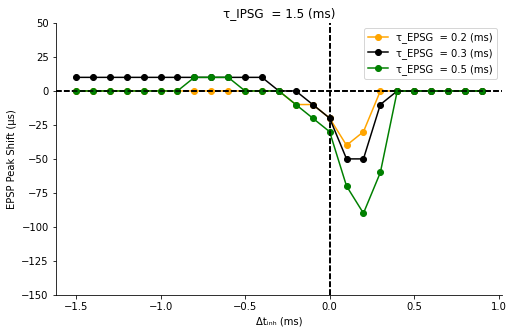

In [6]:
delta_inh_array = np.arange(-1.5,1,0.1)
peak_shift_array = np.zeros((3, len(delta_inh_array)))
tauss = [[0.2, 0.2, 0.2, 1.5], [0.2, 0.2, 0.3, 1.5], [0.2, 0.2, 0.5, 1.5]]
w_e = 1
for j in range(3):
    taus = tauss[j]
    for i in range(len(delta_inh_array)):
        delta_inh = delta_inh_array[i]
        peak_shift_array[j,i] = simulate_mso(delta_inh, taus,w_e, w_ratio, i_ext, tone, time_sim)
        
fig, ax = plt.subplots(1, figsize=(8,5))
colors = ['orange', 'k', 'g']
ax.set_title((unicodeit.replace('τ_IPSG  = {} (ms)')).format(tauss[0][3]))
for j in range(3):
    ax.plot(delta_inh_array, peak_shift_array[j], 'o-', color = colors[j], label = 'τ_EPSG  = {} (ms)'.format(tauss[j][2]))
    ax.set_xlabel(unicodeit.replace('Δt_{inh} (ms)'))
    ax.set_ylabel("EPSP Peak Shift (μs)")
    ax.set_ylim([-150,50])
    ax.axvline(0, color = 'k', linestyle = '--')
    ax.axhline(0, color = 'k', linestyle = '--')
ax.legend()
ax.spines['top'].set_visible(False) 
ax.spines['right'].set_visible(False)

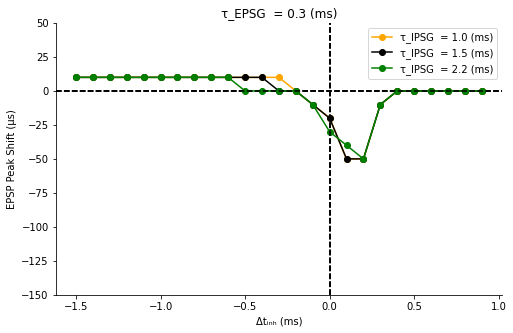

In [7]:
delta_inh_array = np.arange(-1.5,1,0.1)
peak_shift_array = np.zeros((3, len(delta_inh_array)))
tauss = [[0.2, 0.2, 0.3, 1.0], [0.2, 0.2, 0.3, 1.5], [0.2, 0.2, 0.3, 2.2]]
for j in range(3):
    taus = tauss[j]
    for i in range(len(delta_inh_array)):
        delta_inh = delta_inh_array[i]
        peak_shift_array[j,i] = simulate_mso(delta_inh, taus,w_e, w_ratio, i_ext, tone, time_sim)
        
fig, ax = plt.subplots(1, figsize=(8,5))
colors = ['orange', 'k', 'g']
ax.set_title((unicodeit.replace('τ_EPSG  = {} (ms)')).format(tauss[0][2]))
for j in range(3):
    ax.plot(delta_inh_array, peak_shift_array[j], 'o-', color = colors[j], label = 'τ_IPSG  = {} (ms)'.format(tauss[j][3]))
    ax.set_xlabel(unicodeit.replace('Δt_{inh} (ms)'))
    ax.set_ylabel("EPSP Peak Shift (μs)")
    ax.set_ylim([-150,50])
    ax.axvline(0, color = 'k', linestyle = '--')
    ax.axhline(0, color = 'k', linestyle = '--')
ax.legend()
ax.spines['top'].set_visible(False) 
ax.spines['right'].set_visible(False)

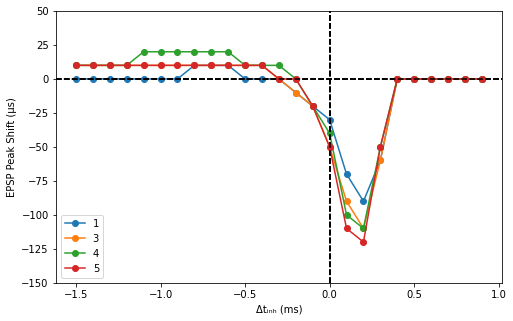

In [132]:
delta_inh_array = np.arange(-1.5,1,0.1)
peak_shift_array = np.zeros((4, len(delta_inh_array)))
taus = [0.2, 0.2, 0.5, 1.5]
w_es = [1,3,4,5]
for j in range(4):
    w_e = w_es[j]
    for i in range(len(delta_inh_array)):
        delta_inh = delta_inh_array[i]
        peak_shift_array[j,i] = simulate_mso(delta_inh, taus, w_e, w_ratio, i_ext, tone, time_sim)
        
fig, ax = plt.subplots(1, figsize=(8,5))
ax.set_title((unicodeit.replace('τ_EPSG  = {} (ms)')).format(taus[2]))
for j in range(4):
    ax.plot(delta_inh_array, peak_shift_array[j], 'o-', label = w_es[j])
    ax.set_xlabel(unicodeit.replace('Δt_{inh} (ms)'))
    ax.set_ylabel("EPSP Peak Shift (μs)")
    ax.set_ylim([-150,50])
    ax.axvline(0, color = 'k', linestyle = '--')
    ax.axhline(0, color = 'k', linestyle = '--')
ax.legend()

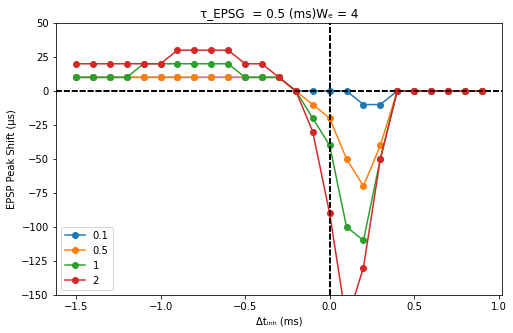

In [13]:
delta_inh_array = np.arange(-1.5,1,0.1)
peak_shift_array = np.zeros((4, len(delta_inh_array)))
taus = [0.2, 0.2, 0.5, 1.5]
w_e = 4
w_ratios = [0.1, 0.5, 1, 2]
for j in range(4):
    w_ratio = w_ratios[j]
    for i in range(len(delta_inh_array)):
        delta_inh = delta_inh_array[i]
        peak_shift_array[j,i] = simulate_mso(delta_inh, taus, w_e, w_ratio, i_ext, tone, time_sim)
        
fig, ax = plt.subplots(1, figsize=(8,5))
ax.set_title(unicodeit.replace('τ_EPSG  = {} (ms)').format(taus[2])+unicodeit.replace('W_e = {}').format(w_e))
for j in range(4):
    ax.plot(delta_inh_array, peak_shift_array[j], 'o-', label = w_ratios[j])
    ax.set_xlabel(unicodeit.replace('Δt_{inh} (ms)'))
    ax.set_ylabel("EPSP Peak Shift (μs)")
    ax.set_ylim([-150,50])
    ax.axvline(0, color = 'k', linestyle = '--')
    ax.axhline(0, color = 'k', linestyle = '--')
ax.legend()

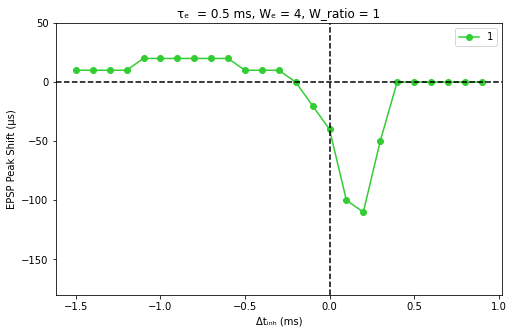

In [22]:
fig, ax = plt.subplots(1, figsize=(8,5))
ax.set_title(unicodeit.replace('τ_e  = {} ms').format(taus[2])+unicodeit.replace(', W_e = {}').format(w_e) + (', W_ratio = {}').format(w_ratios[2]))
for j in range(2,3):
    ax.plot(delta_inh_array, peak_shift_array[j], 'o-', label = w_ratios[2], color = 'limegreen')
    ax.set_xlabel(unicodeit.replace('Δt_{inh} (ms)'))
    ax.set_ylabel("EPSP Peak Shift (μs)")
    ax.set_ylim([-180,50])
    ax.axvline(0, color = 'k', linestyle = '--')
    ax.axhline(0, color = 'k', linestyle = '--')
ax.legend()

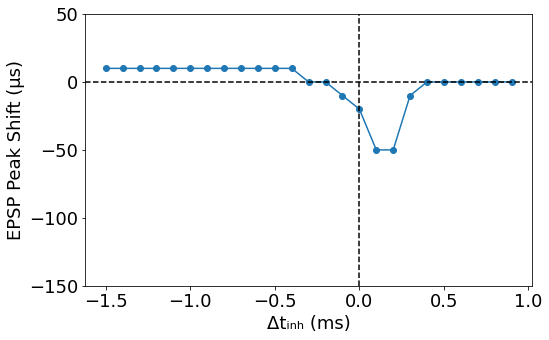

In [18]:
delta_inh_array = np.arange(-1.5,1,0.1)
peak_shift_array = np.zeros(len(delta_inh_array))
taus = [0.2, 0.2, 0.3, 1.5]
for i in range(len(delta_inh_array)):
    delta_inh = delta_inh_array[i]
    peak_shift_array[i] = simulate_mso(delta_inh, taus, w_ratio, i_ext, tone, time_sim)
        
fig, ax = plt.subplots(1, figsize=(8,5))

ax.plot(delta_inh_array, peak_shift_array, 'o-')
ax.set_xlabel(unicodeit.replace('Δt_{inh} (ms)'))
ax.set_ylabel("EPSP Peak Shift (μs)")
ax.set_ylim([-150,50])
ax.axvline(0, color = 'k', linestyle = '--')
ax.axhline(0, color = 'k', linestyle = '--')
#print(f"{w_ratio=}")
#for i in range(len(peak_shift_array)):
    #print(np.round(delta_inh_array[i],2), 'ms', np.round(peak_shift_array[i],2), 'us\n')

# 3 PSPs summation (1 IPSP)

In [11]:
angle = 0
w_head = 22 #cm
v_sound = 33000 #cm/s
delta_x = (w_head*np.sin(np.deg2rad(angle)))
itd = round(1000*delta_x/v_sound,2)  #ms
print('ITD = {}'.format(itd*1000) + ' (μs)')

ITD = 0.0 (μs)


ipsi_peak_shift 0.0 us
contra_peak_shift 10.0 us


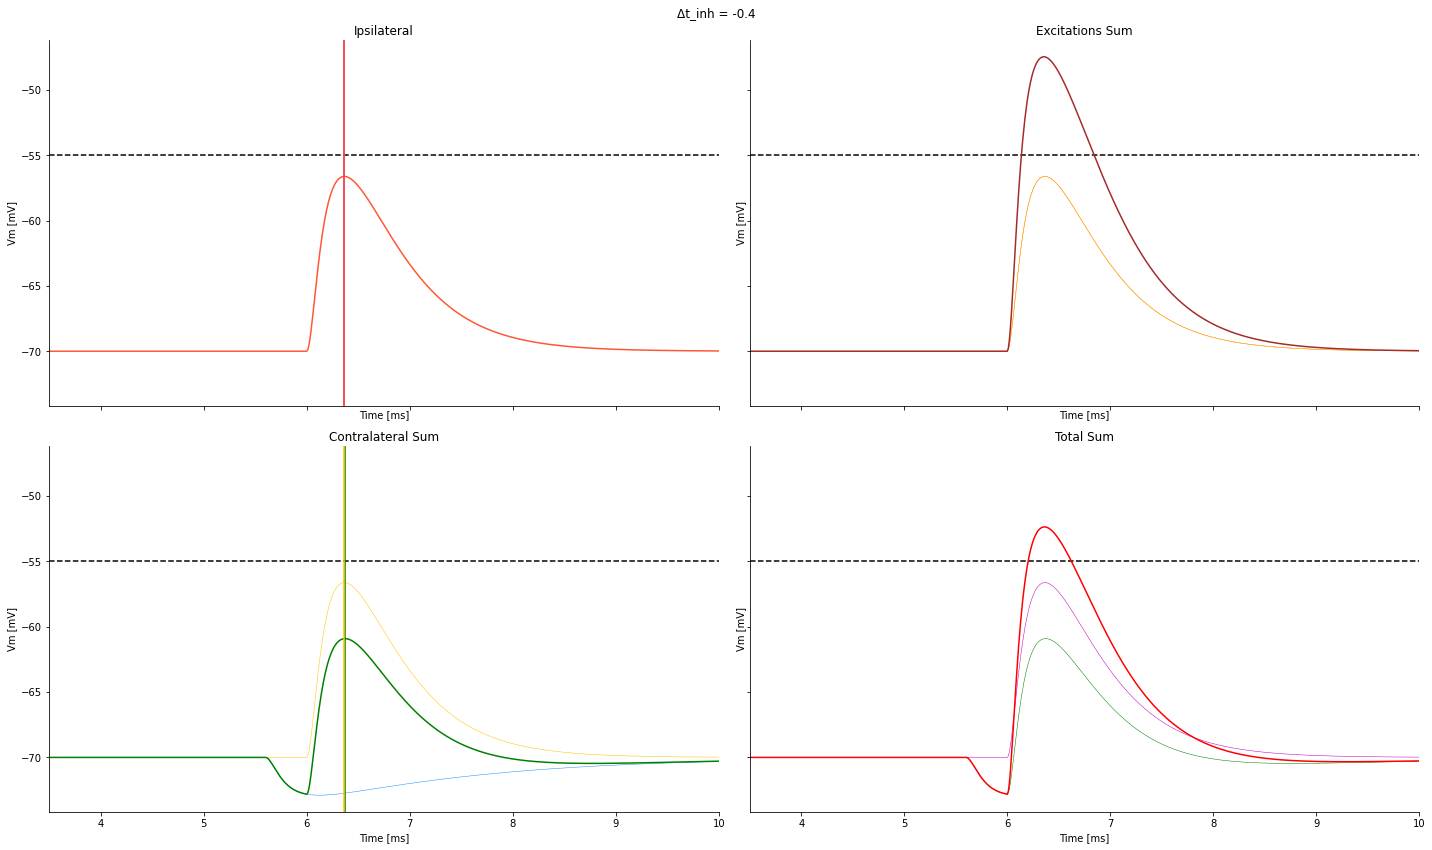

In [12]:
tone = 100
time_sim = 15
lim = time_sim

delta_inh = -0.4
w_ratio = 1
we = 4
taus =  [0.2, 0.2, 0.5, 1.5] #default: [0.2, 2, 0.2, 2] #avgMyoga[x,x,0.3,1.5]  #bestMyoga[x,x,0.5,1]

c_mso = 1
wi = -we*w_ratio
delays_mso = [5,5,5,5+delta_inh] #ms
weights_mso = [we,wi]
v_th = -40
v_m = -70

nest.ResetKernel()
nest.local_num_threads = 16
nest.resolution = 0.01 

ipsi_e = nest.Create("spike_generator", 1, params={"spike_times": np.around(np.arange(1+itd, time_sim+1, 1000/tone),2)})
contra_e = nest.Create("spike_generator", 1, params={"spike_times": np.around(np.arange(1, time_sim+1, 1000/tone),2)})

mso = nest.Create('iaf_cond_beta', 8)

for i in range(8):
    mso[i].set(V_m = v_m, V_th = v_th, C_m = c_mso, tau_rise_ex = taus[0], tau_rise_in = taus[1], tau_decay_ex = taus[2], tau_decay_in = taus[3])

m = nest.Create('multimeter', 1, {"record_from": ['V_m']})
nest.SetStatus(m, {'interval': 0.01})

nest.Connect(m, mso, 'all_to_all')

nest.Connect(ipsi_e, mso[0], 'one_to_one', syn_spec = {"weight":weights_mso[0], "delay": delays_mso[0]})
nest.Connect(contra_e, mso[2], 'one_to_one', syn_spec = {"weight":weights_mso[0], "delay": delays_mso[2]})
nest.Connect(contra_e, mso[3], 'one_to_one', syn_spec = {"weight":weights_mso[1], "delay": delays_mso[3]})

nest.Connect(ipsi_e, mso[4], 'one_to_one', syn_spec = {"weight":weights_mso[0], "delay": delays_mso[0]})

nest.Connect(contra_e, mso[5], 'one_to_one', syn_spec = {"weight":weights_mso[0], "delay": delays_mso[2]})
nest.Connect(contra_e, mso[5], 'one_to_one', syn_spec = {"weight":weights_mso[1], "delay": delays_mso[3]})

nest.Connect(ipsi_e, mso[6], 'one_to_one', syn_spec = {"weight":weights_mso[0], "delay": delays_mso[0]})
nest.Connect(contra_e, mso[6], 'one_to_one', syn_spec = {"weight":weights_mso[0], "delay": delays_mso[2]})

nest.Connect(ipsi_e, mso[7], 'one_to_one', syn_spec = {"weight":weights_mso[0], "delay": delays_mso[0]})
nest.Connect(contra_e, mso[7], 'one_to_one', syn_spec = {"weight":weights_mso[0], "delay": delays_mso[2]})
nest.Connect(contra_e, mso[7], 'one_to_one', syn_spec = {"weight":weights_mso[1], "delay": delays_mso[3]})

nest.Simulate(time_sim)
#data = s.get('events')
pot = m.get('events')

col = ['#FF5733', '#33A1FD', '#FFC300', '#1E90FF', 'm', 'g', 'brown', 'red']
fig, ax = plt.subplots(2,2, figsize=(20,12), sharex = True, sharey = True)
lim = [3.5,10]
ax[0,0].set_xlim(lim)

for j in range(2):
    for i in range(2):
        ax[i, j].set_xlim(lim)
        ax[i, j].axhline(y = -55, color = 'k', linestyle = '--')
        ax[i, j].spines['top'].set_visible(False)
        ax[i, j].spines['right'].set_visible(False)
        ax[i, j].set_xlabel("Time [ms]")
        ax[i, j].set_ylabel("Vm [mV]")
        
ax[0, 0].set_title('Ipsilateral')
ax[1, 0].set_title('Contralateral Sum')
ax[0, 1].set_title('Excitations Sum')
ax[1, 1].set_title('Total Sum')

ax[0, 0].plot(pot['times'][np.where(pot['senders'] == mso[0].get('global_id'))], pot['V_m'][np.where(pot['senders'] == mso[0].get('global_id'))], color = col[0])

ax[1, 0].plot(pot['times'][np.where(pot['senders'] == mso[2].get('global_id'))], pot['V_m'][np.where(pot['senders'] == mso[2].get('global_id'))], color = col[2], linewidth = 0.5)
ax[1, 0].plot(pot['times'][np.where(pot['senders'] == mso[3].get('global_id'))], pot['V_m'][np.where(pot['senders'] == mso[3].get('global_id'))], color = col[3], linewidth = 0.5)
ax[1, 0].plot(pot['times'][np.where(pot['senders'] == mso[5].get('global_id'))], pot['V_m'][np.where(pot['senders'] == mso[5].get('global_id'))], color = col[5])

ax[0, 1].plot(pot['times'][np.where(pot['senders'] == mso[0].get('global_id'))], pot['V_m'][np.where(pot['senders'] == mso[0].get('global_id'))], color = col[0], linewidth = 0.5)
ax[0, 1].plot(pot['times'][np.where(pot['senders'] == mso[2].get('global_id'))], pot['V_m'][np.where(pot['senders'] == mso[2].get('global_id'))], color = col[2], linewidth = 0.5)
ax[0, 1].plot(pot['times'][np.where(pot['senders'] == mso[6].get('global_id'))], pot['V_m'][np.where(pot['senders'] == mso[6].get('global_id'))], color = col[6])

ax[1, 1].plot(pot['times'][np.where(pot['senders'] == mso[4].get('global_id'))], pot['V_m'][np.where(pot['senders'] == mso[4].get('global_id'))], color = col[4], linewidth = 0.5)
ax[1, 1].plot(pot['times'][np.where(pot['senders'] == mso[5].get('global_id'))], pot['V_m'][np.where(pot['senders'] == mso[5].get('global_id'))], color = col[5], linewidth = 0.5)
ax[1, 1].plot(pot['times'][np.where(pot['senders'] == mso[7].get('global_id'))], pot['V_m'][np.where(pot['senders'] == mso[7].get('global_id'))], color = col[7])

#Ipsilateral
t_both = pot['times'][max(range(len(pot['V_m'][np.where(pot['senders'] == mso[4])])), key=pot['V_m'][np.where(pot['senders'] == mso[4])].__getitem__)]
t_exc = pot['times'][max(range(len(pot['V_m'][np.where(pot['senders'] == mso[0])])), key=pot['V_m'][np.where(pot['senders'] == mso[0])].__getitem__)]
ax[0,0].axvline(t_both, color = col[4])
ax[0,0].axvline(t_exc, color = col[0])
peak_shift = (t_both - t_exc)*1000
print('ipsi_peak_shift', round(peak_shift,4), 'us')

#Contralateral
t_both = pot['times'][max(range(len(pot['V_m'][np.where(pot['senders'] == mso[5])])), key=pot['V_m'][np.where(pot['senders'] == mso[5])].__getitem__)]
t_exc = pot['times'][max(range(len(pot['V_m'][np.where(pot['senders'] == mso[2])])), key=pot['V_m'][np.where(pot['senders'] == mso[2])].__getitem__)]
ax[1,0].axvline(t_both, color = col[5])
ax[1,0].axvline(t_exc, color = col[2])
peak_shift = (t_both - t_exc)*1000
print('contra_peak_shift', round(peak_shift,4), 'us')
fig.suptitle('Δt_inh = {}'.format(delta_inh))
fig.tight_layout()


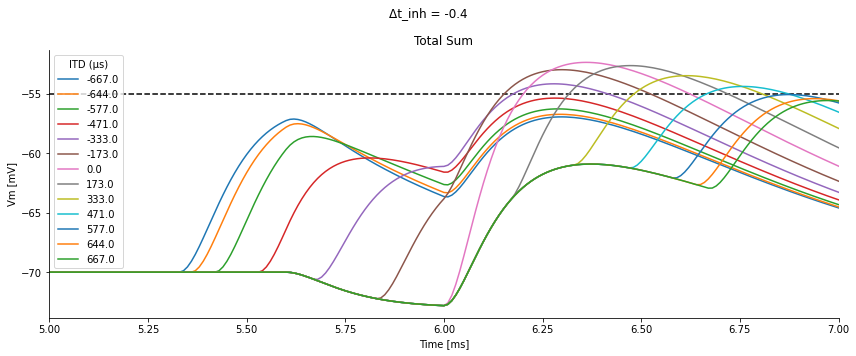

In [145]:
w_head = 22
angles = np.arange(-90,100,15)
delta_x = (w_head*np.sin(np.deg2rad(angles)))
itds = 1000*delta_x/v_sound #ms

fig, ax = plt.subplots(1, figsize=(12,5), sharex = True, sharey = True)
lim = [5,7]
ax.set_xlim(lim)
ax.axhline(y = -55, color = 'k', linestyle = '--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("Time [ms]")
ax.set_ylabel("Vm [mV]")
ax.set_title('Total Sum')

for angle in angles:

    delta_x = (w_head*np.sin(np.deg2rad(angle)))
    itd = 1000*delta_x/v_sound #ms

    nest.ResetKernel()
    nest.local_num_threads = 16
    nest.resolution = 0.01 

    ipsi_e = nest.Create("spike_generator", 1, params={"spike_times": np.around(np.arange(1+itd, time_sim+1, 1000/tone),2)})
    contra_e = nest.Create("spike_generator", 1, params={"spike_times": np.around(np.arange(1, time_sim+1, 1000/tone),2)})

    mso = nest.Create('iaf_cond_beta', 1)

    for i in range(1):
        mso[i].set(V_m = v_m, V_th = v_th, C_m = c_mso, tau_rise_ex = taus[0], tau_rise_in = taus[1], tau_decay_ex = taus[2], tau_decay_in = taus[3])

    m = nest.Create('multimeter', 1, {"record_from": ['V_m']})
    nest.SetStatus(m, {'interval': 0.01})

    nest.Connect(m, mso, 'all_to_all')

    nest.Connect(ipsi_e, mso[0], 'one_to_one', syn_spec = {"weight":weights_mso[0], "delay": delays_mso[0]})
    nest.Connect(contra_e, mso[0], 'one_to_one', syn_spec = {"weight":weights_mso[0], "delay": delays_mso[2]})
    nest.Connect(contra_e, mso[0], 'one_to_one', syn_spec = {"weight":weights_mso[1], "delay": delays_mso[3]})

    nest.Simulate(time_sim)
    #data = s.get('events')
    pot = m.get('events')
    ax.plot(pot['times'][np.where(pot['senders'] == mso[0].get('global_id'))], pot['V_m'][np.where(pot['senders'] == mso[0].get('global_id'))], label = np.round(1000*itd))
    ax.legend(title="ITD (μs)")
    fig.suptitle('Δt_inh = {}'.format(delta_inh))
    fig.tight_layout()


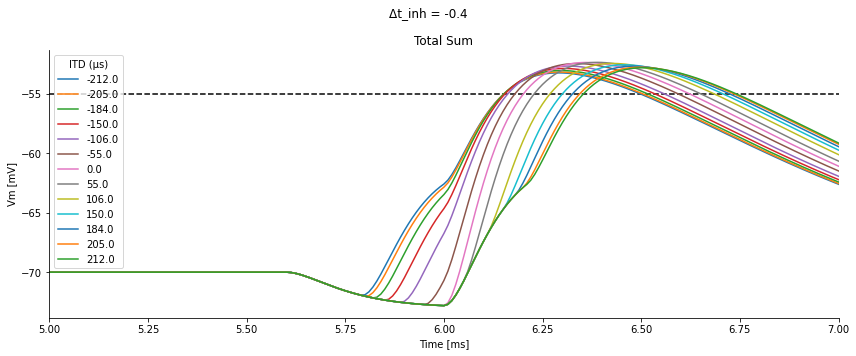

In [146]:
w_head = 7
angles = np.arange(-90,100,15)
delta_x = (w_head*np.sin(np.deg2rad(angles)))
itds = 1000*delta_x/v_sound #ms

fig, ax = plt.subplots(1, figsize=(12,5), sharex = True, sharey = True)
lim = [5,7]
ax.set_xlim(lim)
ax.axhline(y = -55, color = 'k', linestyle = '--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("Time [ms]")
ax.set_ylabel("Vm [mV]")
ax.set_title('Total Sum')

for angle in angles:

    delta_x = (w_head*np.sin(np.deg2rad(angle)))
    itd = 1000*delta_x/v_sound #ms

    nest.ResetKernel()
    nest.local_num_threads = 16
    nest.resolution = 0.01 

    ipsi_e = nest.Create("spike_generator", 1, params={"spike_times": np.around(np.arange(1+itd, time_sim+1, 1000/tone),2)})
    contra_e = nest.Create("spike_generator", 1, params={"spike_times": np.around(np.arange(1, time_sim+1, 1000/tone),2)})

    mso = nest.Create('iaf_cond_beta', 1)

    for i in range(1):
        mso[i].set(V_m = v_m, V_th = v_th, C_m = c_mso, tau_rise_ex = taus[0], tau_rise_in = taus[1], tau_decay_ex = taus[2], tau_decay_in = taus[3])

    m = nest.Create('multimeter', 1, {"record_from": ['V_m']})
    nest.SetStatus(m, {'interval': 0.01})

    nest.Connect(m, mso, 'all_to_all')

    nest.Connect(ipsi_e, mso[0], 'one_to_one', syn_spec = {"weight":weights_mso[0], "delay": delays_mso[0]})
    nest.Connect(contra_e, mso[0], 'one_to_one', syn_spec = {"weight":weights_mso[0], "delay": delays_mso[2]})
    nest.Connect(contra_e, mso[0], 'one_to_one', syn_spec = {"weight":weights_mso[1], "delay": delays_mso[3]})

    nest.Simulate(time_sim)
    #data = s.get('events')
    pot = m.get('events')
    ax.plot(pot['times'][np.where(pot['senders'] == mso[0].get('global_id'))], pot['V_m'][np.where(pot['senders'] == mso[0].get('global_id'))], label = np.round(1000*itd))
    ax.legend(title="ITD (μs)")
    fig.suptitle('Δt_inh = {}'.format(delta_inh))
    fig.tight_layout()


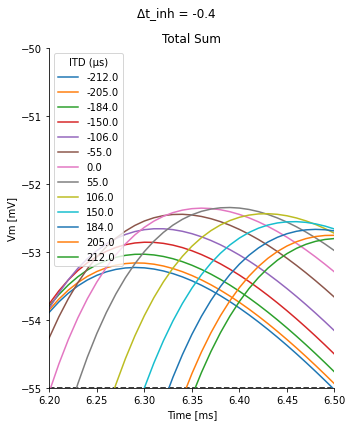

In [149]:
w_head = 7
angles = np.arange(-90,100,15)
delta_x = (w_head*np.sin(np.deg2rad(angles)))
itds = 1000*delta_x/v_sound #ms

fig, ax = plt.subplots(1, figsize=(5,6), sharex = True, sharey = True)
lim = [6.2,6.5]
ax.set_xlim(lim)
ax.set_ylim([-55,-50])
ax.axhline(y = -55, color = 'k', linestyle = '--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("Time [ms]")
ax.set_ylabel("Vm [mV]")
ax.set_title('Total Sum')

for angle in angles:

    delta_x = (w_head*np.sin(np.deg2rad(angle)))
    itd = 1000*delta_x/v_sound #ms

    nest.ResetKernel()
    nest.local_num_threads = 16
    nest.resolution = 0.01 

    ipsi_e = nest.Create("spike_generator", 1, params={"spike_times": np.around(np.arange(1+itd, time_sim+1, 1000/tone),2)})
    contra_e = nest.Create("spike_generator", 1, params={"spike_times": np.around(np.arange(1, time_sim+1, 1000/tone),2)})

    mso = nest.Create('iaf_cond_beta', 1)

    for i in range(1):
        mso[i].set(V_m = v_m, V_th = v_th, C_m = c_mso, tau_rise_ex = taus[0], tau_rise_in = taus[1], tau_decay_ex = taus[2], tau_decay_in = taus[3])

    m = nest.Create('multimeter', 1, {"record_from": ['V_m']})
    nest.SetStatus(m, {'interval': 0.01})

    nest.Connect(m, mso, 'all_to_all')

    nest.Connect(ipsi_e, mso[0], 'one_to_one', syn_spec = {"weight":weights_mso[0], "delay": delays_mso[0]})
    nest.Connect(contra_e, mso[0], 'one_to_one', syn_spec = {"weight":weights_mso[0], "delay": delays_mso[2]})
    nest.Connect(contra_e, mso[0], 'one_to_one', syn_spec = {"weight":weights_mso[1], "delay": delays_mso[3]})

    nest.Simulate(time_sim)
    #data = s.get('events')
    pot = m.get('events')
    ax.plot(pot['times'][np.where(pot['senders'] == mso[0].get('global_id'))], pot['V_m'][np.where(pot['senders'] == mso[0].get('global_id'))], label = np.round(1000*itd))
    ax.legend(title="ITD (μs)")
    fig.suptitle('Δt_inh = {}'.format(delta_inh))
    fig.tight_layout()


In [6]:
def deltat_itd_curve_i(itds, delta_inh_array, taus):
    best_inh = np.zeros((len(delta_inh_array),2))
    best_inh[:, 0] = -100

    for i in range(len(delta_inh_array)):

        delta_inh = delta_inh_array[i]
        #print('--------------')
        #print(delta_inh, 'ms')
        
        delays_mso = [5,5,5+delta_inh] #ms

        for j in range(len(itds)):

            itd = itds[j]

            nest.ResetKernel()
            nest.local_num_threads = 16
            nest.resolution = 0.01 

            ipsi_e = nest.Create("spike_generator", 1, params={"spike_times": np.around(np.arange(1 + itd, time_sim+1, 1000/tone),2)})
            contra_e = nest.Create("spike_generator", 1, params={"spike_times": np.around(np.arange(1, time_sim+1, 1000/tone),2)})

            mso = nest.Create('iaf_cond_beta', 1)

            mso[0].set(V_th = v_th, C_m = c_mso, tau_rise_ex = taus[0], tau_rise_in = taus[1], tau_decay_ex = taus[2], tau_decay_in = taus[3])

            m = nest.Create('multimeter', 1, {"record_from": ['V_m']})
            nest.SetStatus(m, {'interval': 0.01})

            nest.Connect(m, mso, 'all_to_all')

            nest.Connect(ipsi_e, mso[0], 'one_to_one', syn_spec = {"weight":weights_mso[0], "delay": delays_mso[0]})
            nest.Connect(contra_e, mso[0], 'one_to_one', syn_spec = {"weight":weights_mso[0], "delay": delays_mso[1]})
            nest.Connect(ipsi_e, mso[0], 'one_to_one', syn_spec = {"weight":weights_mso[1], "delay": delays_mso[2]})

            nest.Simulate(time_sim)

            pot = m.get('events')

            if(np.max(pot['V_m']) > best_inh[i,0]):
                best_inh[i,0] = np.max(pot['V_m'])
                best_inh[i,1] = itd*1000
            #print('-----')
            #print('Angle = ', angles[j], '°')
            #print('ITD = ', np.round(itd*1000,2), 'us')
            #print('Peak Value = ', np.round(np.max(pot['V_m']),2), 'mV')

        #print('--> Best Peak Value: ', np.round(best_inh[i,0],2), 'mV')
        #print('--> Best ITD: ', np.round(best_inh[i,1],2), 'μs')
    return best_inh[:,1]

In [5]:
def deltat_itd_curve_c(itds, delta_inh_array, taus):
    best_inh = np.zeros((len(delta_inh_array),2))
    best_inh[:, 0] = -100

    for i in range(len(delta_inh_array)):

        delta_inh = delta_inh_array[i]
        #print('--------------')
        #print(delta_inh, 'ms')
        
        delays_mso = [5,5,5+delta_inh] #ms

        for j in range(len(itds)):

            itd = itds[j]

            nest.ResetKernel()
            nest.local_num_threads = 16
            nest.resolution = 0.01 

            ipsi_e = nest.Create("spike_generator", 1, params={"spike_times": np.around(np.arange(1 + itd, time_sim+1, 1000/tone),2)})
            contra_e = nest.Create("spike_generator", 1, params={"spike_times": np.around(np.arange(1, time_sim+1, 1000/tone),2)})

            mso = nest.Create('iaf_cond_beta', 1)

            mso[0].set(V_th = v_th, C_m = c_mso, tau_rise_ex = taus[0], tau_rise_in = taus[1], tau_decay_ex = taus[2], tau_decay_in = taus[3])

            m = nest.Create('multimeter', 1, {"record_from": ['V_m']})
            nest.SetStatus(m, {'interval': 0.01})

            nest.Connect(m, mso, 'all_to_all')

            nest.Connect(ipsi_e, mso[0], 'one_to_one', syn_spec = {"weight":weights_mso[0], "delay": delays_mso[0]})
            nest.Connect(contra_e, mso[0], 'one_to_one', syn_spec = {"weight":weights_mso[0], "delay": delays_mso[1]})
            nest.Connect(contra_e, mso[0], 'one_to_one', syn_spec = {"weight":weights_mso[1], "delay": delays_mso[2]})

            nest.Simulate(time_sim)

            pot = m.get('events')

            if(np.max(pot['V_m']) > best_inh[i,0]):
                best_inh[i,0] = np.max(pot['V_m'])
                best_inh[i,1] = itd*1000
            #print('-----')
            #print('Angle = ', angles[j], '°')
            #print('ITD = ', np.round(itd*1000,2), 'us')
            #print('Peak Value = ', np.round(np.max(pot['V_m']),2), 'mV')

        #print('--> Best Peak Value: ', np.round(best_inh[i,0],2), 'mV')
        #print('--> Best ITD: ', np.round(best_inh[i,1],2), 'μs')
    return best_inh[:,1]

In [77]:
delta_x = (w_head*np.sin(np.deg2rad(angles)))
itds = 1000*delta_x/v_sound #ms
delta_inh_array = np.arange(-1.5,1,0.1)
taus = [0.2,0.2,0.5,1.5]
best_inh = deltat_itd_curve(itds,delta_inh_array,taus)

In [64]:
taus = [0.2,0.2,0.3,1.5]
best_inh1 = deltat_itd_curve(itds,delta_inh_array,taus)

--------------
-1.5 ms
-----
Angle =  -90 °
ITD =  -212.12 us
Peak Value =  -51.63 mV
-----
Angle =  -75 °
ITD =  -204.89 us
Peak Value =  -51.53 mV
-----
Angle =  -60 °
ITD =  -183.7 us
Peak Value =  -51.32 mV
-----
Angle =  -45 °
ITD =  -149.99 us
Peak Value =  -51.05 mV
-----
Angle =  -30 °
ITD =  -106.06 us
Peak Value =  -50.74 mV
-----
Angle =  -15 °
ITD =  -54.9 us
Peak Value =  -50.42 mV
-----
Angle =  0 °
ITD =  0.0 us
Peak Value =  -50.3 mV
-----
Angle =  15 °
ITD =  54.9 us
Peak Value =  -50.33 mV
-----
Angle =  30 °
ITD =  106.06 us
Peak Value =  -50.55 mV
-----
Angle =  45 °
ITD =  149.99 us
Peak Value =  -50.8 mV
-----
Angle =  60 °
ITD =  183.7 us
Peak Value =  -51.03 mV
-----
Angle =  75 °
ITD =  204.89 us
Peak Value =  -51.2 mV
-----
Angle =  90 °
ITD =  212.12 us
Peak Value =  -51.29 mV
--> Best Peak Value:  -50.3 mV
--> Best ITD:  0.0 μs
--------------
-1.4 ms
-----
Angle =  -90 °
ITD =  -212.12 us
Peak Value =  -51.81 mV
-----
Angle =  -75 °
ITD =  -204.89 us
Peak Va

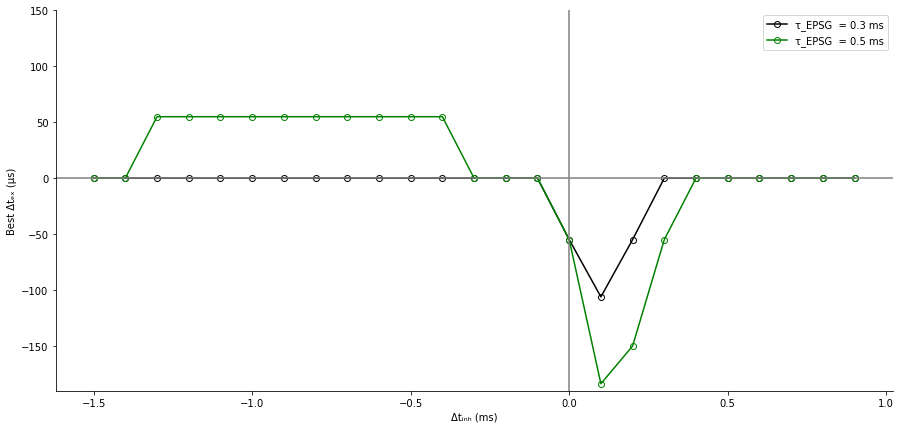

In [66]:
delta_inh_array = np.arange(-1.5,1,0.1)


fig, ax = plt.subplots(1, figsize=(15,7))
ax.plot(delta_inh_array, best_inh1,  marker='o', linestyle='-', color='k', markerfacecolor='none', label = 'τ_EPSG  = 0.3 ms')
ax.plot(delta_inh_array, best_inh,  marker='o', linestyle='-', color='g', markerfacecolor='none', label = 'τ_EPSG  = 0.5 ms')
ax.set_xlabel(unicodeit.replace('Δt_{inh} (ms)'))
ax.set_ylabel(unicodeit.replace('Best Δt_{ex} (μs)'))
ax.set_ylim([-190,150])
ax.axvline(0, color = 'grey')
ax.axhline(0, color = 'grey')
ax.legend()
ax.spines['top'].set_visible(False) 
ax.spines['right'].set_visible(False)

# 4 PSPs summation (2 IPSPs)

In [24]:
angle = 0
w_head = 22 #cm
v_sound = 33000 #cm/s
delta_x = (w_head*np.sin(np.deg2rad(angle)))
itd = round(1000*delta_x/v_sound,2)  #ms
print('ITD = {}'.format(itd*1000) + ' (μs)')

ITD = 0.0 (μs)


ipsi_peak_shift -110.0 us
contra_peak_shift 10.0 us


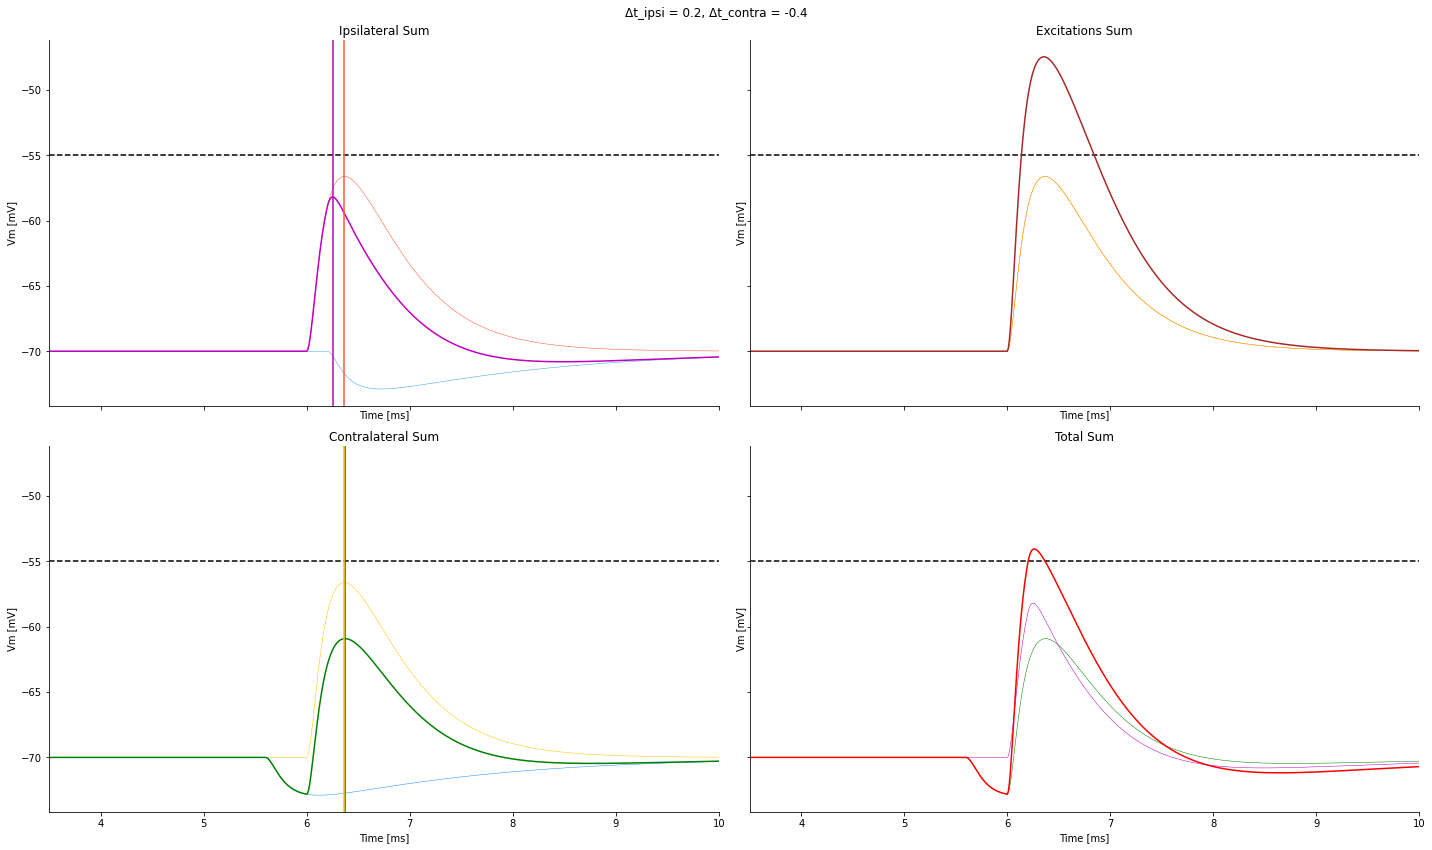

In [13]:
tone = 100
time_sim = 15
lim = time_sim
delta_ipsi = 0.2
delta_contra = -0.4

w_ratio = 1
we = 4

taus = np.zeros(4)
taus[:] =  [0.2, 0.2, 0.5, 1.5] #default: [0.2, 2, 0.2, 2] #avgMyoga[x,x,0.3,1.5]  #bestMyoga[x,x,0.5,1]

c_mso = 1
wi = -we*w_ratio
delays_mso = [5,5+delta_ipsi,5,5+delta_contra] #ms
weights_mso = [we,wi]
v_th = -40
v_m = -70

nest.ResetKernel()
nest.local_num_threads = 16
nest.resolution = 0.01 

ipsi_e = nest.Create("spike_generator", 1, params={"spike_times": np.around(np.arange(1+itd, time_sim+1, 1000/tone),2)})
contra_e = nest.Create("spike_generator", 1, params={"spike_times": np.around(np.arange(1, time_sim+1, 1000/tone),2)})

mso = nest.Create('iaf_cond_beta', 8)

for i in range(8):
    mso[i].set(V_m = v_m, V_th = v_th, C_m = c_mso, tau_rise_ex = taus[0], tau_rise_in = taus[1], tau_decay_ex = taus[2], tau_decay_in = taus[3])

m = nest.Create('multimeter', 1, {"record_from": ['V_m']})
nest.SetStatus(m, {'interval': 0.01})

nest.Connect(m, mso, 'all_to_all')

nest.Connect(ipsi_e, mso[0], 'one_to_one', syn_spec = {"weight":weights_mso[0], "delay": delays_mso[0]})
nest.Connect(ipsi_e, mso[1], 'one_to_one', syn_spec = {"weight":weights_mso[1], "delay": delays_mso[1]})
nest.Connect(contra_e, mso[2], 'one_to_one', syn_spec = {"weight":weights_mso[0], "delay": delays_mso[2]})
nest.Connect(contra_e, mso[3], 'one_to_one', syn_spec = {"weight":weights_mso[1], "delay": delays_mso[3]})

nest.Connect(ipsi_e, mso[4], 'one_to_one', syn_spec = {"weight":weights_mso[0], "delay": delays_mso[0]})
nest.Connect(ipsi_e, mso[4], 'one_to_one', syn_spec = {"weight":weights_mso[1], "delay": delays_mso[1]})

nest.Connect(contra_e, mso[5], 'one_to_one', syn_spec = {"weight":weights_mso[0], "delay": delays_mso[2]})
nest.Connect(contra_e, mso[5], 'one_to_one', syn_spec = {"weight":weights_mso[1], "delay": delays_mso[3]})

nest.Connect(ipsi_e, mso[6], 'one_to_one', syn_spec = {"weight":weights_mso[0], "delay": delays_mso[0]})
nest.Connect(contra_e, mso[6], 'one_to_one', syn_spec = {"weight":weights_mso[0], "delay": delays_mso[2]})

nest.Connect(ipsi_e, mso[7], 'one_to_one', syn_spec = {"weight":weights_mso[0], "delay": delays_mso[0]})
nest.Connect(ipsi_e, mso[7], 'one_to_one', syn_spec = {"weight":weights_mso[1], "delay": delays_mso[1]})
nest.Connect(contra_e, mso[7], 'one_to_one', syn_spec = {"weight":weights_mso[0], "delay": delays_mso[2]})
nest.Connect(contra_e, mso[7], 'one_to_one', syn_spec = {"weight":weights_mso[1], "delay": delays_mso[3]})

nest.Simulate(time_sim)
#data = s.get('events')
pot = m.get('events')

col = ['#FF5733', '#33A1FD', '#FFC300', '#1E90FF', 'm', 'g', 'brown', 'red']
fig, ax = plt.subplots(2,2, figsize=(20,12), sharex = True, sharey = True)
lim = [3.5,10]
ax[0,0].set_xlim(lim)

for j in range(2):
    for i in range(2):
        ax[i, j].set_xlim(lim)
        ax[i, j].axhline(y = -55, color = 'k', linestyle = '--')
        ax[i, j].spines['top'].set_visible(False)
        ax[i, j].spines['right'].set_visible(False)
        ax[i, j].set_xlabel("Time [ms]")
        ax[i, j].set_ylabel("Vm [mV]")
        
ax[0, 0].set_title('Ipsilateral Sum')
ax[1, 0].set_title('Contralateral Sum')
ax[0, 1].set_title('Excitations Sum')
ax[1, 1].set_title('Total Sum')

ax[0, 0].plot(pot['times'][np.where(pot['senders'] == mso[0].get('global_id'))], pot['V_m'][np.where(pot['senders'] == mso[0].get('global_id'))], color = col[0], linewidth = 0.5)
ax[0, 0].plot(pot['times'][np.where(pot['senders'] == mso[1].get('global_id'))], pot['V_m'][np.where(pot['senders'] == mso[1].get('global_id'))], color = col[1], linewidth = 0.5)
ax[0, 0].plot(pot['times'][np.where(pot['senders'] == mso[4].get('global_id'))], pot['V_m'][np.where(pot['senders'] == mso[4].get('global_id'))], color = col[4])

ax[1, 0].plot(pot['times'][np.where(pot['senders'] == mso[2].get('global_id'))], pot['V_m'][np.where(pot['senders'] == mso[2].get('global_id'))], color = col[2], linewidth = 0.5)
ax[1, 0].plot(pot['times'][np.where(pot['senders'] == mso[3].get('global_id'))], pot['V_m'][np.where(pot['senders'] == mso[3].get('global_id'))], color = col[3], linewidth = 0.5)
ax[1, 0].plot(pot['times'][np.where(pot['senders'] == mso[5].get('global_id'))], pot['V_m'][np.where(pot['senders'] == mso[5].get('global_id'))], color = col[5])

ax[0, 1].plot(pot['times'][np.where(pot['senders'] == mso[0].get('global_id'))], pot['V_m'][np.where(pot['senders'] == mso[0].get('global_id'))], color = col[0], linewidth = 0.5)
ax[0, 1].plot(pot['times'][np.where(pot['senders'] == mso[2].get('global_id'))], pot['V_m'][np.where(pot['senders'] == mso[2].get('global_id'))], color = col[2], linewidth = 0.5)
ax[0, 1].plot(pot['times'][np.where(pot['senders'] == mso[6].get('global_id'))], pot['V_m'][np.where(pot['senders'] == mso[6].get('global_id'))], color = col[6])

ax[1, 1].plot(pot['times'][np.where(pot['senders'] == mso[4].get('global_id'))], pot['V_m'][np.where(pot['senders'] == mso[4].get('global_id'))], color = col[4], linewidth = 0.5)
ax[1, 1].plot(pot['times'][np.where(pot['senders'] == mso[5].get('global_id'))], pot['V_m'][np.where(pot['senders'] == mso[5].get('global_id'))], color = col[5], linewidth = 0.5)
ax[1, 1].plot(pot['times'][np.where(pot['senders'] == mso[7].get('global_id'))], pot['V_m'][np.where(pot['senders'] == mso[7].get('global_id'))], color = col[7])

#Ipsilateral
t_both = pot['times'][max(range(len(pot['V_m'][np.where(pot['senders'] == mso[4])])), key=pot['V_m'][np.where(pot['senders'] == mso[4])].__getitem__)]
t_exc = pot['times'][max(range(len(pot['V_m'][np.where(pot['senders'] == mso[0])])), key=pot['V_m'][np.where(pot['senders'] == mso[0])].__getitem__)]
ax[0,0].axvline(t_both, color = col[4])
ax[0,0].axvline(t_exc, color = col[0])
peak_shift = (t_both - t_exc)*1000
print('ipsi_peak_shift', round(peak_shift,4), 'us')

#Contralateral
t_both = pot['times'][max(range(len(pot['V_m'][np.where(pot['senders'] == mso[5])])), key=pot['V_m'][np.where(pot['senders'] == mso[5])].__getitem__)]
t_exc = pot['times'][max(range(len(pot['V_m'][np.where(pot['senders'] == mso[2])])), key=pot['V_m'][np.where(pot['senders'] == mso[2])].__getitem__)]
ax[1,0].axvline(t_both, color = col[5])
ax[1,0].axvline(t_exc, color = col[2])
peak_shift = (t_both - t_exc)*1000
print('contra_peak_shift', round(peak_shift,4), 'us')
fig.suptitle('Δt_ipsi = {}, Δt_contra = {}'.format(delta_ipsi, delta_contra))
fig.tight_layout()


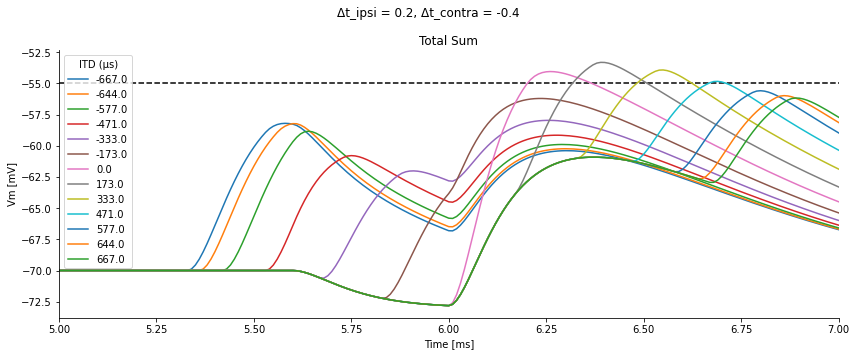

In [14]:
w_head = 22 #cm
angles = np.arange(-90,100,15)
delta_x = (w_head*np.sin(np.deg2rad(angles)))
itds = 1000*delta_x/v_sound #ms

fig, ax = plt.subplots(1, figsize=(12,5), sharex = True, sharey = True)
lim = [5,7]
ax.set_xlim(lim)
ax.axhline(y = -55, color = 'k', linestyle = '--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("Time [ms]")
ax.set_ylabel("Vm [mV]")
ax.set_title('Total Sum')

for angle in angles:

    delta_x = (w_head*np.sin(np.deg2rad(angle)))
    itd = 1000*delta_x/v_sound #ms

    nest.ResetKernel()
    nest.local_num_threads = 16
    nest.resolution = 0.01 

    ipsi_e = nest.Create("spike_generator", 1, params={"spike_times": np.around(np.arange(1+itd, time_sim+1, 1000/tone),2)})
    contra_e = nest.Create("spike_generator", 1, params={"spike_times": np.around(np.arange(1, time_sim+1, 1000/tone),2)})

    mso = nest.Create('iaf_cond_beta', 1)

    for i in range(1):
        mso[i].set(V_m = v_m, V_th = v_th, C_m = c_mso, tau_rise_ex = taus[0], tau_rise_in = taus[1], tau_decay_ex = taus[2], tau_decay_in = taus[3])

    m = nest.Create('multimeter', 1, {"record_from": ['V_m']})
    nest.SetStatus(m, {'interval': 0.01})

    nest.Connect(m, mso, 'all_to_all')

    nest.Connect(ipsi_e, mso[0], 'one_to_one', syn_spec = {"weight":weights_mso[0], "delay": delays_mso[0]})
    nest.Connect(ipsi_e, mso[0], 'one_to_one', syn_spec = {"weight":weights_mso[1], "delay": delays_mso[1]})
    nest.Connect(contra_e, mso[0], 'one_to_one', syn_spec = {"weight":weights_mso[0], "delay": delays_mso[2]})
    nest.Connect(contra_e, mso[0], 'one_to_one', syn_spec = {"weight":weights_mso[1], "delay": delays_mso[3]})

    nest.Simulate(time_sim)
    #data = s.get('events')
    pot = m.get('events')
    ax.plot(pot['times'][np.where(pot['senders'] == mso[0].get('global_id'))], pot['V_m'][np.where(pot['senders'] == mso[0].get('global_id'))], label = np.round(1000*itd))
    ax.legend(title="ITD (μs)")
    fig.suptitle('Δt_ipsi = {}, Δt_contra = {}'.format(delta_ipsi, delta_contra))
    fig.tight_layout()


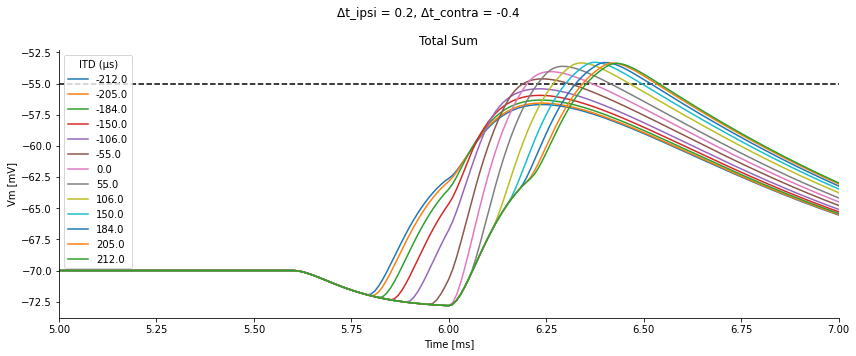

In [152]:
w_head = 7
angles = np.arange(-90,100,15)

fig, ax = plt.subplots(1, figsize=(12,5), sharex = True, sharey = True)
lim = [5,7]
ax.set_xlim(lim)
ax.axhline(y = -55, color = 'k', linestyle = '--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("Time [ms]")
ax.set_ylabel("Vm [mV]")
ax.set_title('Total Sum')

for angle in angles:

    delta_x = (w_head*np.sin(np.deg2rad(angle)))
    itd = 1000*delta_x/v_sound #ms

    nest.ResetKernel()
    nest.local_num_threads = 16
    nest.resolution = 0.01 

    ipsi_e = nest.Create("spike_generator", 1, params={"spike_times": np.around(np.arange(1+itd, time_sim+1, 1000/tone),2)})
    contra_e = nest.Create("spike_generator", 1, params={"spike_times": np.around(np.arange(1, time_sim+1, 1000/tone),2)})

    mso = nest.Create('iaf_cond_beta', 1)

    for i in range(1):
        mso[i].set(V_m = v_m, V_th = v_th, C_m = c_mso, tau_rise_ex = taus[0], tau_rise_in = taus[1], tau_decay_ex = taus[2], tau_decay_in = taus[3])

    m = nest.Create('multimeter', 1, {"record_from": ['V_m']})
    nest.SetStatus(m, {'interval': 0.01})

    nest.Connect(m, mso, 'all_to_all')

    nest.Connect(ipsi_e, mso[0], 'one_to_one', syn_spec = {"weight":weights_mso[0], "delay": delays_mso[0]})
    nest.Connect(ipsi_e, mso[0], 'one_to_one', syn_spec = {"weight":weights_mso[1], "delay": delays_mso[1]})
    nest.Connect(contra_e, mso[0], 'one_to_one', syn_spec = {"weight":weights_mso[0], "delay": delays_mso[2]})
    nest.Connect(contra_e, mso[0], 'one_to_one', syn_spec = {"weight":weights_mso[1], "delay": delays_mso[3]})

    nest.Simulate(time_sim)
    #data = s.get('events')
    pot = m.get('events')
    ax.plot(pot['times'][np.where(pot['senders'] == mso[0].get('global_id'))], pot['V_m'][np.where(pot['senders'] == mso[0].get('global_id'))], label = np.round(1000*itd))
    ax.legend(title="ITD (μs)")
    fig.suptitle('Δt_ipsi = {}, Δt_contra = {}'.format(delta_ipsi, delta_contra))
    fig.tight_layout()


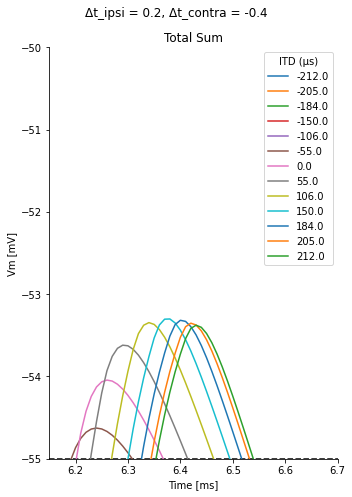

In [155]:
w_head = 7
angles = np.arange(-90,100,15)

fig, ax = plt.subplots(1, figsize=(5,7), sharex = True, sharey = True)
lim = [6.15,6.7]
ax.set_xlim(lim)
ax.set_ylim([-55,-50])
ax.axhline(y = -55, color = 'k', linestyle = '--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("Time [ms]")
ax.set_ylabel("Vm [mV]")
ax.set_title('Total Sum')

for angle in angles:

    delta_x = (w_head*np.sin(np.deg2rad(angle)))
    itd = 1000*delta_x/v_sound #ms

    nest.ResetKernel()
    nest.local_num_threads = 16
    nest.resolution = 0.01 

    ipsi_e = nest.Create("spike_generator", 1, params={"spike_times": np.around(np.arange(1+itd, time_sim+1, 1000/tone),2)})
    contra_e = nest.Create("spike_generator", 1, params={"spike_times": np.around(np.arange(1, time_sim+1, 1000/tone),2)})

    mso = nest.Create('iaf_cond_beta', 1)

    for i in range(1):
        mso[i].set(V_m = v_m, V_th = v_th, C_m = c_mso, tau_rise_ex = taus[0], tau_rise_in = taus[1], tau_decay_ex = taus[2], tau_decay_in = taus[3])

    m = nest.Create('multimeter', 1, {"record_from": ['V_m']})
    nest.SetStatus(m, {'interval': 0.01})

    nest.Connect(m, mso, 'all_to_all')

    nest.Connect(ipsi_e, mso[0], 'one_to_one', syn_spec = {"weight":weights_mso[0], "delay": delays_mso[0]})
    nest.Connect(ipsi_e, mso[0], 'one_to_one', syn_spec = {"weight":weights_mso[1], "delay": delays_mso[1]})
    nest.Connect(contra_e, mso[0], 'one_to_one', syn_spec = {"weight":weights_mso[0], "delay": delays_mso[2]})
    nest.Connect(contra_e, mso[0], 'one_to_one', syn_spec = {"weight":weights_mso[1], "delay": delays_mso[3]})

    nest.Simulate(time_sim)
    #data = s.get('events')
    pot = m.get('events')
    ax.plot(pot['times'][np.where(pot['senders'] == mso[0].get('global_id'))], pot['V_m'][np.where(pot['senders'] == mso[0].get('global_id'))], label = np.round(1000*itd))
    ax.legend(title="ITD (μs)")
    fig.suptitle('Δt_ipsi = {}, Δt_contra = {}'.format(delta_ipsi, delta_contra))
    fig.tight_layout()


In [19]:
def deltat_itd_curve2(itds, single_delta, delta_inh_array, taus, contra_fixed):
    best_inh = np.zeros((len(delta_inh_array),2))
    best_inh[:, 0] = -100

    for i in range(len(delta_inh_array)):
        
        if(contra_fixed):
            delta_ipsi = delta_inh_array[i]
            delta_contra = single_delta
        else:
            delta_contra = delta_inh_array[i]
            delta_ipsi = single_delta
            
        delays_mso = [5,5+delta_ipsi,5,5+delta_contra] #ms
        print('--------------')
        print('delta_ipsi = {}'.format(delta_ipsi), 'ms')
        print('delta_contra = {}'.format(delta_contra), 'ms')
        
        for j in range(len(itds)):

            itd = itds[j]

            nest.ResetKernel()
            nest.local_num_threads = 16
            nest.resolution = 0.01 

            ipsi_e = nest.Create("spike_generator", 1, params={"spike_times": np.around(np.arange(1 + itd, time_sim+1, 1000/tone),2)})
            contra_e = nest.Create("spike_generator", 1, params={"spike_times": np.around(np.arange(1, time_sim+1, 1000/tone),2)})

            mso = nest.Create('iaf_cond_beta', 1)

            mso[0].set(V_th = v_th, C_m = c_mso, tau_rise_ex = taus[0], tau_rise_in = taus[1], tau_decay_ex = taus[2], tau_decay_in = taus[3])

            m = nest.Create('multimeter', 1, {"record_from": ['V_m']})
            nest.SetStatus(m, {'interval': 0.01})

            nest.Connect(m, mso, 'all_to_all')

            nest.Connect(ipsi_e, mso[0], 'one_to_one', syn_spec = {"weight":weights_mso[0], "delay": delays_mso[0]})
            nest.Connect(ipsi_e, mso[0], 'one_to_one', syn_spec = {"weight":weights_mso[1], "delay": delays_mso[1]})
            nest.Connect(contra_e, mso[0], 'one_to_one', syn_spec = {"weight":weights_mso[0], "delay": delays_mso[2]})
            nest.Connect(contra_e, mso[0], 'one_to_one', syn_spec = {"weight":weights_mso[1], "delay": delays_mso[3]})

            nest.Simulate(time_sim)

            pot = m.get('events')

            if(np.max(pot['V_m']) > best_inh[i,0]):
                best_inh[i,0] = np.max(pot['V_m'])
                best_inh[i,1] = itd*1000
            print('-----')
            print('Angle = ', angles[j], '°')
            print('ITD = ', np.round(itd*1000,2), 'us')
            print('Peak Value = ', np.round(np.max(pot['V_m']),2), 'mV')

        print('--> Best Peak Value: ', np.round(best_inh[i,0],2), 'mV')
        print('--> Best ITD: ', np.round(best_inh[i,1],2), 'μs')
    return best_inh[:,1]

In [15]:
w_head = 7
delta_x = (w_head*np.sin(np.deg2rad(angles)))
itds = 1000*delta_x/v_sound #ms
delta_inh_array = np.arange(-1.5,1,0.1)
taus = [0.2,0.2,0.5,1.5]
#best_inh = deltat_itd_curve2(itds,delta_contra,delta_inh_array,taus,1)
best_c = deltat_itd_curve_c(itds,delta_inh_array,taus)


In [16]:
w_head = 7
best_i = deltat_itd_curve_i(itds,delta_inh_array,taus)

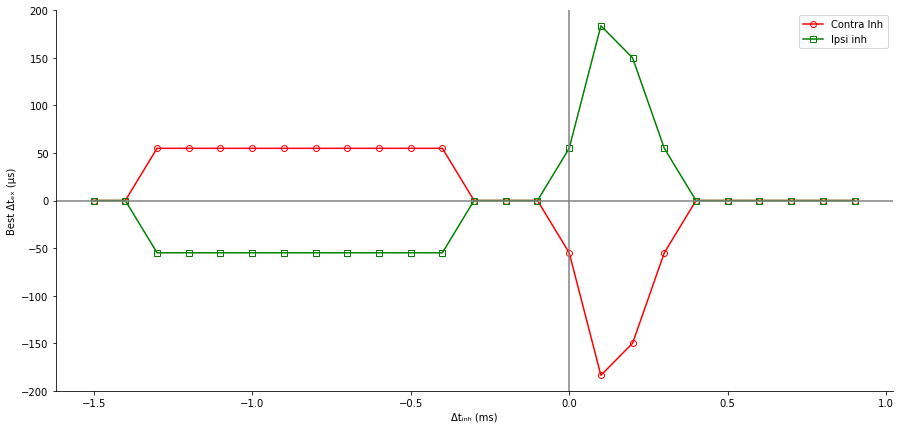

In [17]:
fig, ax = plt.subplots(1, figsize=(15,7))
ax.plot(delta_inh_array, best_c,  marker='o', linestyle='-', color='r', markerfacecolor='none', label = 'Contra Inh')
ax.plot(delta_inh_array, best_i,  marker='s', linestyle='-', color='g', markerfacecolor='none', label = 'Ipsi inh')
ax.set_xlabel(unicodeit.replace('Δt_{inh} (ms)'))
ax.set_ylabel(unicodeit.replace('Best Δt_{ex} (μs)'))
ax.set_ylim([-200,200])
ax.axvline(0, color = 'grey')
ax.axhline(0, color = 'grey')
ax.legend()
ax.spines['top'].set_visible(False) 
ax.spines['right'].set_visible(False)

In [24]:
w_head = 7
delta_x = (w_head*np.sin(np.deg2rad(angles)))
itds = 1000*delta_x/v_sound #ms
delta_inh_array = np.arange(-1.5,1,0.1)
delta_contra = -0.6
taus = [0.2,0.2,0.5,1.5]
best_inh2 = deltat_itd_curve2(itds,delta_contra,delta_inh_array,taus,1)

--------------
delta_ipsi = -1.5 ms
delta_contra = -0.6 ms
-----
Angle =  -90 °
ITD =  -212.12 us
Peak Value =  -54.66 mV
-----
Angle =  -75 °
ITD =  -204.89 us
Peak Value =  -54.61 mV
-----
Angle =  -60 °
ITD =  -183.7 us
Peak Value =  -54.5 mV
-----
Angle =  -45 °
ITD =  -149.99 us
Peak Value =  -54.35 mV
-----
Angle =  -30 °
ITD =  -106.06 us
Peak Value =  -54.19 mV
-----
Angle =  -15 °
ITD =  -54.9 us
Peak Value =  -54.02 mV
-----
Angle =  0 °
ITD =  0.0 us
Peak Value =  -53.97 mV
-----
Angle =  15 °
ITD =  54.9 us
Peak Value =  -53.99 mV
-----
Angle =  30 °
ITD =  106.06 us
Peak Value =  -54.11 mV
-----
Angle =  45 °
ITD =  149.99 us
Peak Value =  -54.24 mV
-----
Angle =  60 °
ITD =  183.7 us
Peak Value =  -54.36 mV
-----
Angle =  75 °
ITD =  204.89 us
Peak Value =  -54.46 mV
-----
Angle =  90 °
ITD =  212.12 us
Peak Value =  -54.5 mV
--> Best Peak Value:  -53.97 mV
--> Best ITD:  0.0 μs
--------------
delta_ipsi = -1.4 ms
delta_contra = -0.6 ms
-----
Angle =  -90 °
ITD =  -212.12

In [31]:
w_head = 7
delta_x = (w_head*np.sin(np.deg2rad(angles)))
itds = 1000*delta_x/v_sound #ms
delta_inh_array = np.arange(-1.5,1,0.1)
delta_ipsi = 0.1
taus = [0.2,0.2,0.5,1.5]
best_inh2 = deltat_itd_curve2(itds,delta_ipsi,delta_inh_array,taus,0)


--------------
delta_ipsi = 0.1 ms
delta_contra = -1.5 ms
-----
Angle =  -90 °
ITD =  -212.12 us
Peak Value =  -55.34 mV
-----
Angle =  -75 °
ITD =  -204.89 us
Peak Value =  -55.25 mV
-----
Angle =  -60 °
ITD =  -183.7 us
Peak Value =  -55.08 mV
-----
Angle =  -45 °
ITD =  -149.99 us
Peak Value =  -54.83 mV
-----
Angle =  -30 °
ITD =  -106.06 us
Peak Value =  -54.5 mV
-----
Angle =  -15 °
ITD =  -54.9 us
Peak Value =  -54.04 mV
-----
Angle =  0 °
ITD =  0.0 us
Peak Value =  -53.69 mV
-----
Angle =  15 °
ITD =  54.9 us
Peak Value =  -53.41 mV
-----
Angle =  30 °
ITD =  106.06 us
Peak Value =  -53.17 mV
-----
Angle =  45 °
ITD =  149.99 us
Peak Value =  -53.1 mV
-----
Angle =  60 °
ITD =  183.7 us
Peak Value =  -53.09 mV
-----
Angle =  75 °
ITD =  204.89 us
Peak Value =  -53.1 mV
-----
Angle =  90 °
ITD =  212.12 us
Peak Value =  -53.11 mV
--> Best Peak Value:  -53.09 mV
--> Best ITD:  183.7 μs
--------------
delta_ipsi = 0.1 ms
delta_contra = -1.4 ms
-----
Angle =  -90 °
ITD =  -212.12 

In [32]:
best_inh1 = best_inh2
best_inh2 = deltat_itd_curve2(itds,0.2,delta_inh_array,taus,0)

--------------
delta_ipsi = 0.2 ms
delta_contra = -1.5 ms
-----
Angle =  -90 °
ITD =  -212.12 us
Peak Value =  -54.89 mV
-----
Angle =  -75 °
ITD =  -204.89 us
Peak Value =  -54.77 mV
-----
Angle =  -60 °
ITD =  -183.7 us
Peak Value =  -54.5 mV
-----
Angle =  -45 °
ITD =  -149.99 us
Peak Value =  -54.08 mV
-----
Angle =  -30 °
ITD =  -106.06 us
Peak Value =  -53.5 mV
-----
Angle =  -15 °
ITD =  -54.9 us
Peak Value =  -52.6 mV
-----
Angle =  0 °
ITD =  0.0 us
Peak Value =  -51.95 mV
-----
Angle =  15 °
ITD =  54.9 us
Peak Value =  -51.48 mV
-----
Angle =  30 °
ITD =  106.06 us
Peak Value =  -51.18 mV
-----
Angle =  45 °
ITD =  149.99 us
Peak Value =  -51.14 mV
-----
Angle =  60 °
ITD =  183.7 us
Peak Value =  -51.16 mV
-----
Angle =  75 °
ITD =  204.89 us
Peak Value =  -51.2 mV
-----
Angle =  90 °
ITD =  212.12 us
Peak Value =  -51.23 mV
--> Best Peak Value:  -51.14 mV
--> Best ITD:  149.99 μs
--------------
delta_ipsi = 0.2 ms
delta_contra = -1.4 ms
-----
Angle =  -90 °
ITD =  -212.12 

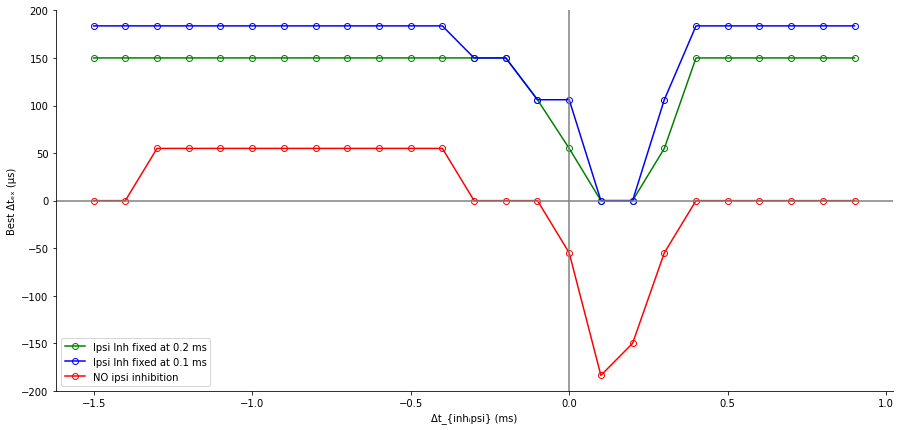

In [34]:
fig, ax = plt.subplots(1, figsize=(15,7))
ax.plot(delta_inh_array, best_inh2,  marker='o', linestyle='-', color='g', markerfacecolor='none', label = 'Ipsi Inh fixed at {} ms'.format(0.2))
ax.plot(delta_inh_array, best_inh1,  marker='o', linestyle='-', color='b', markerfacecolor='none', label = 'Ipsi Inh fixed at {} ms'.format(delta_ipsi))
ax.plot(delta_inh_array, best_c,  marker='o', linestyle='-',  color='r', markerfacecolor='none', label = 'NO ipsi inhibition')
ax.set_xlabel(unicodeit.replace('Δt_{inh_ipsi} (ms)'))
ax.set_ylabel(unicodeit.replace('Best Δt_{ex} (μs)'))
ax.set_ylim([-200,200])
ax.axvline(0, color = 'grey')
ax.axhline(0, color = 'grey')
ax.legend()
ax.spines['top'].set_visible(False) 
ax.spines['right'].set_visible(False)

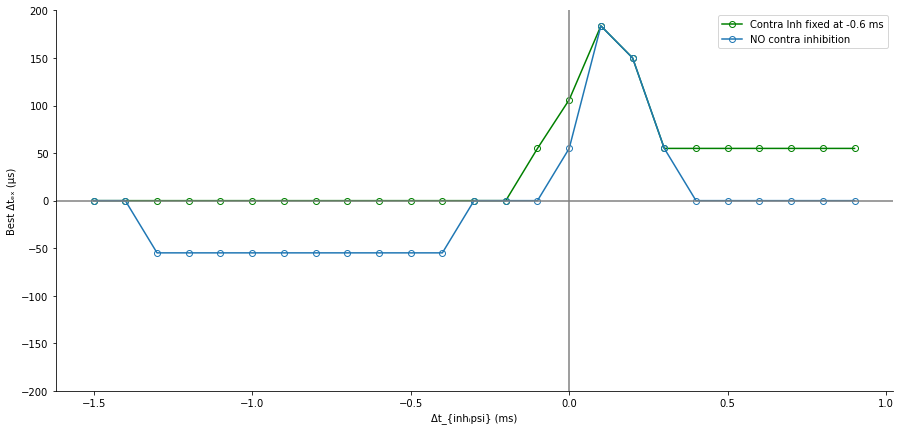

In [26]:
fig, ax = plt.subplots(1, figsize=(15,7))
ax.plot(delta_inh_array, best_inh2,  marker='o', linestyle='-', color='g', markerfacecolor='none', label = 'Contra Inh fixed at {} ms'.format(delta_contra))
ax.plot(delta_inh_array, best_i,  marker='o', linestyle='-',  markerfacecolor='none', label = 'NO contra inhibition')
ax.set_xlabel(unicodeit.replace('Δt_{inh_ipsi} (ms)'))
ax.set_ylabel(unicodeit.replace('Best Δt_{ex} (μs)'))
ax.set_ylim([-200,200])
ax.axvline(0, color = 'grey')
ax.axhline(0, color = 'grey')
ax.legend()
ax.spines['top'].set_visible(False) 
ax.spines['right'].set_visible(False)

# PSPs HF summation


Jun 10 14:46:58 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.01 ms.

Jun 10 14:46:58 NodeManager::prepare_nodes [Info]: 
    Preparing 51 nodes for simulation.

Jun 10 14:46:58 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 51
    Simulation time (ms): 25
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Jun 10 14:46:58 SimulationManager::run [Info]: 
    Simulation finished.
____________________________________________
t_both:  6.390000000000001
t_exc_only:  6.37
First Peak Shift =  20.0 us
____________________________________________

Jun 10 14:46:58 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.01 ms.

Jun 10 14:46:58 NodeManager::prepare_nodes [Info]: 
    Preparing 34 nodes for simulation.
t_both:  [ 6.39 16.39]

Jun 10 14:46:58 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 34
    Simulation time (ms): 25
    Number of OpenMP threads: 16
 

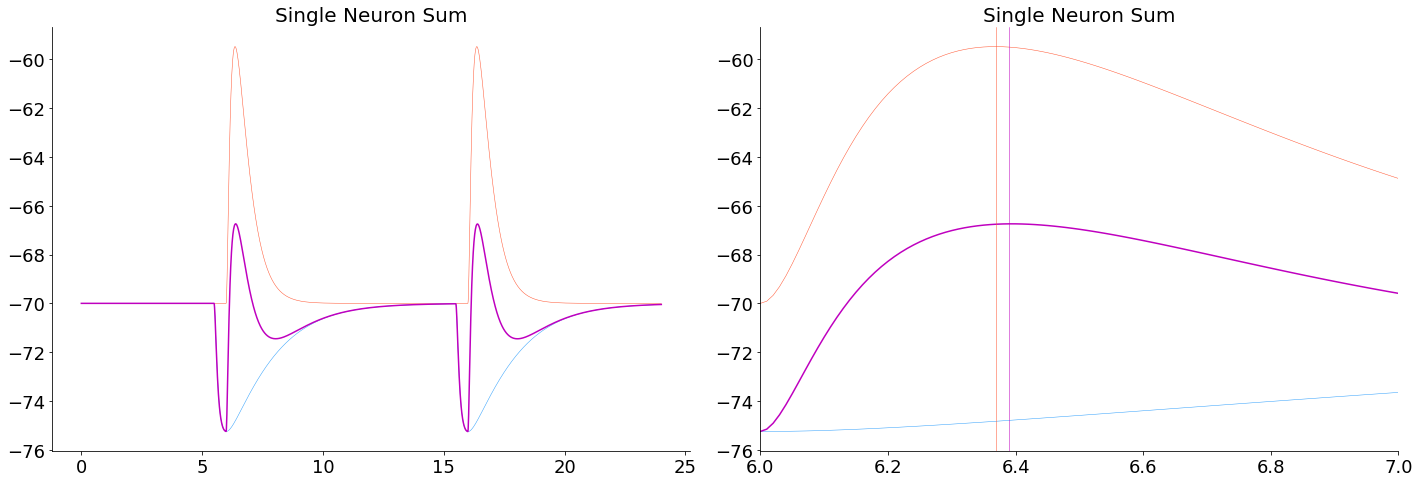

In [42]:
tone = 100
time_sim = 25
lim = time_sim
delta_inh = -0.5
w_ratio = 3

taus = np.zeros(4)
taus[:] =  [0.2, 0.2, 0.5, 1.5] #default: [0.2, 2, 0.2, 2] #avgMyoga[x,x,0.3,1.5]  #bestMyoga[x,x,0.5,1]

c_mso = 1
we = 3
wi = -we*w_ratio
delays_mso = [5,5+delta_inh] #ms
weights_mso = [we,wi]
v_th = -40
v_m = -70

nest.ResetKernel()
nest.local_num_threads = 16
nest.resolution = 0.01 

ipsi_e = nest.Create("spike_generator", 1, params={"spike_times": np.around(np.arange(1, time_sim+1, 1000/tone),2)})


mso = nest.Create('iaf_cond_beta', 3)

for i in range(3):
    mso[i].set(V_m = v_m, V_th = v_th, C_m = c_mso, tau_rise_ex = taus[0], tau_rise_in = taus[1], tau_decay_ex = taus[2], tau_decay_in = taus[3])

s = nest.Create('spike_recorder')

m = nest.Create('multimeter', 1, {"record_from": ['V_m']})
nest.SetStatus(m, {'interval': 0.01})

nest.Connect(mso, s, 'all_to_all')
nest.Connect(ipsi_e, s, 'one_to_one')

nest.Connect(m, mso, 'all_to_all')

nest.Connect(ipsi_e, mso[0], 'one_to_one', syn_spec = {"weight":weights_mso[0], "delay": delays_mso[0]})
nest.Connect(ipsi_e, mso[1], 'one_to_one', syn_spec = {"weight":weights_mso[1], "delay": delays_mso[1]})
nest.Connect(ipsi_e, mso[2], 'one_to_one', syn_spec = {"weight":weights_mso[0], "delay": delays_mso[0]})
nest.Connect(ipsi_e, mso[2], 'one_to_one', syn_spec = {"weight":weights_mso[1], "delay": delays_mso[1]})


nest.Simulate(time_sim)
#data = s.get('events')
pot = m.get('events')

text_color = 'black' 
rcParams['text.color'] = text_color 
rcParams['axes.labelcolor'] = text_color 
rcParams['xtick.color'] = text_color 
rcParams['ytick.color'] = text_color 
plt.rc('font', size=16)          # controls default text sizes 
plt.rc('axes', titlesize=20)     # fontsize of the axes title 
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels 
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels 
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels 
plt.rc('legend', fontsize=16)    # legend fontsize 
plt.rc('figure', titlesize=26)  # fontsize of the figure title

col = ['#FF5733', '#33A1FD', '#FFC300', '#1E90FF', 'm', 'g', 'brown', 'grey']
fig, ax = plt.subplots(1,2, figsize=(20,7))

for i in range(2):
    ax[i].set_title('Single Neuron Sum')
    ax[i].plot(pot['times'][np.where(pot['senders'] == mso[0].get('global_id'))], pot['V_m'][np.where(pot['senders'] == mso[0].get('global_id'))], color = col[0], linewidth = 0.5)
    ax[i].plot(pot['times'][np.where(pot['senders'] == mso[1].get('global_id'))], pot['V_m'][np.where(pot['senders'] == mso[1].get('global_id'))], color = col[1], linewidth = 0.5)
    ax[i].plot(pot['times'][np.where(pot['senders'] == mso[2].get('global_id'))], pot['V_m'][np.where(pot['senders'] == mso[2].get('global_id'))], color = col[4])
    ax[i].spines['top'].set_visible(False) 
    ax[i].spines['right'].set_visible(False)
    
ax[1].set_xlim([6,7])

#First Peak Shift
t_both = pot['times'][np.where(pot['V_m'] == np.max(pot['V_m'][np.where((pot['senders'] == mso[2]) & (pot['times'] < 5 + 1000/tone + 1))]))][0]
t_exc = pot['times'][np.where(pot['V_m'] == np.max(pot['V_m'][np.where((pot['senders'] == mso[0]) & (pot['times'] < 5 + 1000/tone + 1))]))][0]
ax[1].axvline(t_both, color = col[4], linewidth = 0.5)
print('____________________________________________')
print('t_both: ', t_both)
print('t_exc_only: ', t_exc)
ax[1].axvline(t_exc, color = col[0], linewidth = 0.5)
peak_shift = (t_both - t_exc)*1000
print('First Peak Shift = ', round(peak_shift,4), 'us')
print('____________________________________________')

avg_peak_shift = simulate_mso2(delta_inh, taus, w_ratio, tone, time_sim, -70)
print('Avg Peak Shift = ', np.round(np.mean(avg_peak_shift),2), 'us')
fig.tight_layout()

In [67]:
delta_inh_array = np.arange(-2.25,2.25,0.05)
peak_shift_array = np.zeros_like(delta_inh_array)
for i in range(len(delta_inh_array)):
    delta_inh = delta_inh_array[i]
    peak_shift_array[i] = simulate_mso2(delta_inh, taus, w_ratio, tone, time_sim, -70)


Jun 10 09:08:13 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.01 ms.

Jun 10 09:08:13 NodeManager::prepare_nodes [Info]: 
    Preparing 34 nodes for simulation.

Jun 10 09:08:13 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 34
    Simulation time (ms): 25
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Jun 10 09:08:13 SimulationManager::run [Info]: 
    Simulation finished.
t_both:  [ 6.26  7.51  8.76 10.01 11.26 12.51 13.76 15.01 16.26 17.51 18.76 20.01
 21.26 22.51 23.76]
t_exc:  [ 6.37  7.59  8.84 10.09 11.34 12.59 13.84 15.09 16.34 17.59 18.84 20.09
 21.34 22.59 23.84]
peak_shift_array:  [-110.  -80.  -80.  -80.  -80.  -80.  -80.  -80.  -80.  -80.  -80.  -80.
  -80.  -80.  -80.]

Jun 10 09:08:13 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.01 ms.

t_both: Jun 10 09:08:13 NodeManager::prepare_nodes [Info]: 
    Preparing 34 nodes for simulation.

Jun 10 09:08:13 

w_ratio=3


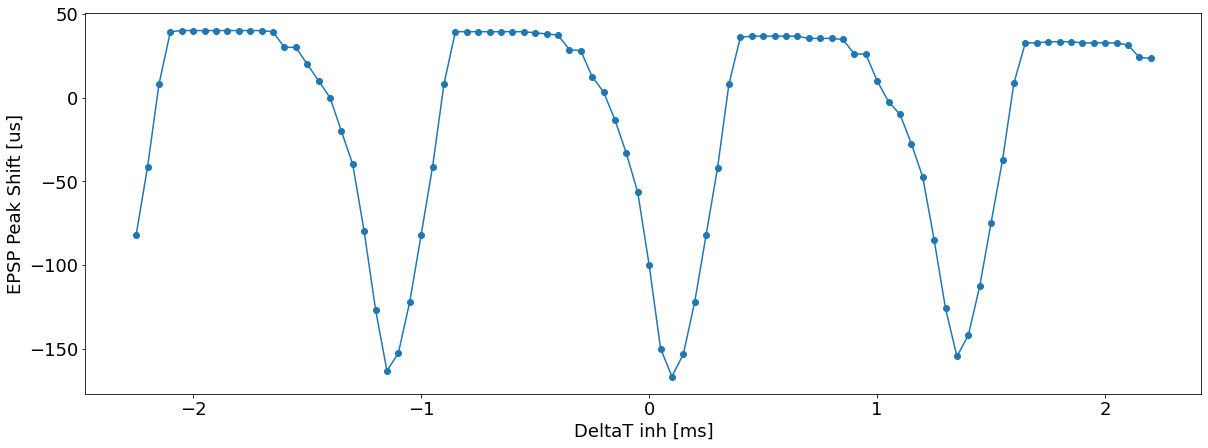

In [68]:
fig, ax = plt.subplots(1, figsize=(20,7))
    
ax.plot(delta_inh_array, peak_shift_array, 'o-')
ax.set_xlabel("DeltaT inh [ms]")
ax.set_ylabel("EPSP Peak Shift [us]")
print(f"{w_ratio=}")
#for i in range(len(peak_shift_array)):
    #print(np.round(delta_inh_array[i],2), 'ms', np.round(peak_shift_array[i],2), 'us\n')

w_ratio=1


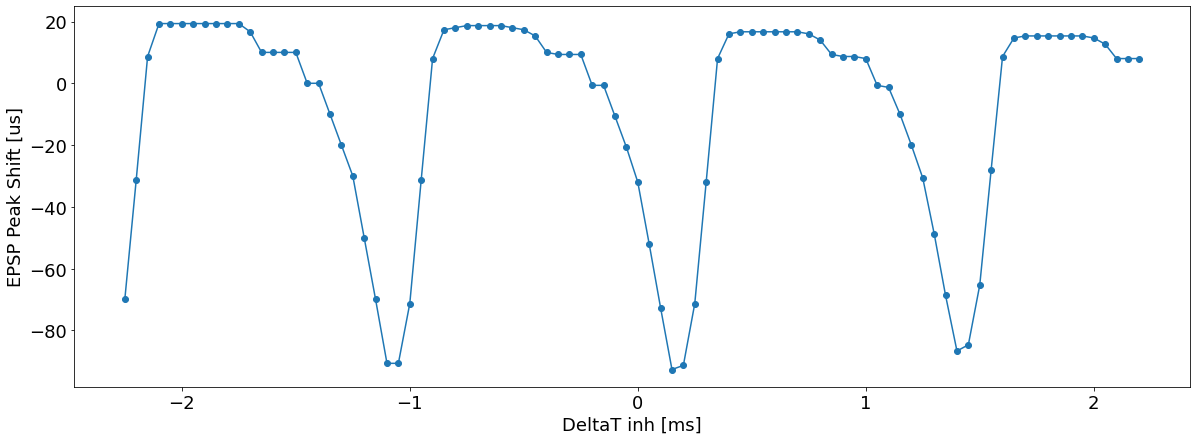

In [65]:
fig, ax = plt.subplots(1, figsize=(20,7))
    
ax.plot(delta_inh_array, peak_shift_array, 'o-')
ax.set_xlabel("DeltaT inh [ms]")
ax.set_ylabel("EPSP Peak Shift [us]")
print(f"{w_ratio=}")
#for i in range(len(peak_shift_array)):
    #print(np.round(delta_inh_array[i],2), 'ms', np.round(peak_shift_array[i],2), 'us\n')

In [162]:
delta_inh_array = np.arange(-1.5,1,0.1)
best_contra = np.zeros((len(delta_inh_array),2))
best_contra[:, 0] = -100

delta_ipsi = 0.2

for i in range(len(delta_inh_array)):
    
    delta_contra = delta_inh_array[i]
    
    delays_mso = [5,5+delta_ipsi,5,5+delta_contra] #ms
    print('--------------')
    print(delta_contra, 'ms')

    for j in range(len(itds)):
        
        itd = itds[j]

        nest.ResetKernel()
        nest.local_num_threads = 16
        nest.resolution = 0.01 

        ipsi_e = nest.Create("spike_generator", 1, params={"spike_times": np.around(np.arange(1, time_sim+1, 1000/tone),2)})
        contra_e = nest.Create("spike_generator", 1, params={"spike_times": np.around(np.arange(1 + itd, time_sim+1, 1000/tone),2)})

        mso = nest.Create('iaf_cond_beta', 1)

        mso[0].set(V_th = v_th, C_m = c_mso, tau_rise_ex = taus[0], tau_rise_in = taus[1], tau_decay_ex = taus[2], tau_decay_in = taus[3])

        m = nest.Create('multimeter', 1, {"record_from": ['V_m']})
        nest.SetStatus(m, {'interval': 0.01})

        nest.Connect(m, mso, 'all_to_all')

        nest.Connect(ipsi_e, mso[0], 'one_to_one', syn_spec = {"weight":weights_mso[0], "delay": delays_mso[0]})
        nest.Connect(ipsi_e, mso[0], 'one_to_one', syn_spec = {"weight":weights_mso[1], "delay": delays_mso[1]})
        nest.Connect(contra_e, mso[0], 'one_to_one', syn_spec = {"weight":weights_mso[0], "delay": delays_mso[2]})
        nest.Connect(contra_e, mso[0], 'one_to_one', syn_spec = {"weight":weights_mso[1], "delay": delays_mso[3]})

        nest.Simulate(time_sim)

        pot = m.get('events')
        
        if(np.max(pot['V_m']) > best_contra[i,0]):
            best_contra[i,0] = np.max(pot['V_m'])
            best_contra[i,1] = itd*1000
        
        print('Angle = ', angles[j], '°')
        print('ITD = ', np.round(itd*1000,2), 'μs')
        print('Peak Value = ', np.round(np.max(pot['V_m']),2), 'mV')
        
    print('--> Best Peak Value: ', np.round(best_contra[i,0],2), 'mV')
    print('--> Best ITD: ', np.round(best_contra[i,1],2), 'μs')

--------------
-1.5 ms
Angle =  -15 °
ITD =  -172.55 μs
Peak Value =  -52.06 mV
Angle =  -14 °
ITD =  -161.28 μs
Peak Value =  -52.0 mV
Angle =  -13 °
ITD =  -149.97 μs
Peak Value =  -51.95 mV
Angle =  -12 °
ITD =  -138.61 μs
Peak Value =  -51.9 mV
Angle =  -11 °
ITD =  -127.21 μs
Peak Value =  -51.87 mV
Angle =  -10 °
ITD =  -115.77 μs
Peak Value =  -51.84 mV
Angle =  -9 °
ITD =  -104.29 μs
Peak Value =  -51.79 mV
Angle =  -8 °
ITD =  -92.78 μs
Peak Value =  -51.78 mV
Angle =  -7 °
ITD =  -81.25 μs
Peak Value =  -51.78 mV
Angle =  -6 °
ITD =  -69.69 μs
Peak Value =  -51.79 mV
Angle =  -5 °
ITD =  -58.1 μs
Peak Value =  -51.82 mV
Angle =  -4 °
ITD =  -46.5 μs
Peak Value =  -51.85 mV
Angle =  -3 °
ITD =  -34.89 μs
Peak Value =  -51.94 mV
Angle =  -2 °
ITD =  -23.27 μs
Peak Value =  -52.01 mV
Angle =  -1 °
ITD =  -11.63 μs
Peak Value =  -52.09 mV
Angle =  0 °
ITD =  0.0 μs
Peak Value =  -52.18 mV
Angle =  1 °
ITD =  11.63 μs
Peak Value =  -52.28 mV
Angle =  2 °
ITD =  23.27 μs
Peak Value

In [163]:
delta_inh_array = np.arange(-1.5,1,0.1)
best_ipsi = np.zeros((len(delta_inh_array),2))
best_ipsi[:, 0] = -100

delta_contra = 0.2

for i in range(len(delta_inh_array)):
    
    delta_ipsi = delta_inh_array[i]
    
    delays_mso = [5,5+delta_ipsi,5,5+delta_contra] #ms
    print('--------------')
    print(delta_ipsi, 'ms')

    for j in range(len(itds)):
        
        itd = itds[j]

        nest.ResetKernel()
        nest.local_num_threads = 16
        nest.resolution = 0.01 

        ipsi_e = nest.Create("spike_generator", 1, params={"spike_times": np.around(np.arange(1, time_sim+1, 1000/tone),2)})
        contra_e = nest.Create("spike_generator", 1, params={"spike_times": np.around(np.arange(1 + itd, time_sim+1, 1000/tone),2)})

        mso = nest.Create('iaf_cond_beta', 1)

        mso[0].set(V_th = v_th, C_m = c_mso, tau_rise_ex = taus[0], tau_rise_in = taus[1], tau_decay_ex = taus[2], tau_decay_in = taus[3])

        m = nest.Create('multimeter', 1, {"record_from": ['V_m']})
        nest.SetStatus(m, {'interval': 0.01})

        nest.Connect(m, mso, 'all_to_all')

        nest.Connect(ipsi_e, mso[0], 'one_to_one', syn_spec = {"weight":weights_mso[0], "delay": delays_mso[0]})
        nest.Connect(ipsi_e, mso[0], 'one_to_one', syn_spec = {"weight":weights_mso[1], "delay": delays_mso[1]})
        nest.Connect(contra_e, mso[0], 'one_to_one', syn_spec = {"weight":weights_mso[0], "delay": delays_mso[2]})
        nest.Connect(contra_e, mso[0], 'one_to_one', syn_spec = {"weight":weights_mso[1], "delay": delays_mso[3]})

        nest.Simulate(time_sim)

        pot = m.get('events')
        
        if(np.max(pot['V_m']) > best_ipsi[i,0]):
            best_ipsi[i,0] = np.max(pot['V_m'])
            best_ipsi[i,1] = itd*1000
        
        print('Angle = ', angles[j], '°')
        print('ITD = ', np.round(itd*1000,2), 'us')
        print('Peak Value = ', np.round(np.max(pot['V_m']),2), 'mV')
        
    print('--> Best Peak Value: ', np.round(best_ipsi[i,0],2), 'mV')
    print('--> Best ITD: ', np.round(best_ipsi[i,1],2), 'μs')

--------------
-1.5 ms
Angle =  -15 °
ITD =  -172.55 us
Peak Value =  -55.0 mV
Angle =  -14 °
ITD =  -161.28 us
Peak Value =  -54.8 mV
Angle =  -13 °
ITD =  -149.97 us
Peak Value =  -54.61 mV
Angle =  -12 °
ITD =  -138.61 us
Peak Value =  -54.42 mV
Angle =  -11 °
ITD =  -127.21 us
Peak Value =  -54.22 mV
Angle =  -10 °
ITD =  -115.77 us
Peak Value =  -54.03 mV
Angle =  -9 °
ITD =  -104.29 us
Peak Value =  -53.65 mV
Angle =  -8 °
ITD =  -92.78 us
Peak Value =  -53.47 mV
Angle =  -7 °
ITD =  -81.25 us
Peak Value =  -53.29 mV
Angle =  -6 °
ITD =  -69.69 us
Peak Value =  -53.12 mV
Angle =  -5 °
ITD =  -58.1 us
Peak Value =  -52.96 mV
Angle =  -4 °
ITD =  -46.5 us
Peak Value =  -52.8 mV
Angle =  -3 °
ITD =  -34.89 us
Peak Value =  -52.52 mV
Angle =  -2 °
ITD =  -23.27 us
Peak Value =  -52.4 mV
Angle =  -1 °
ITD =  -11.63 us
Peak Value =  -52.28 mV
Angle =  0 °
ITD =  0.0 us
Peak Value =  -52.18 mV
Angle =  1 °
ITD =  11.63 us
Peak Value =  -52.09 mV
Angle =  2 °
ITD =  23.27 us
Peak Value =

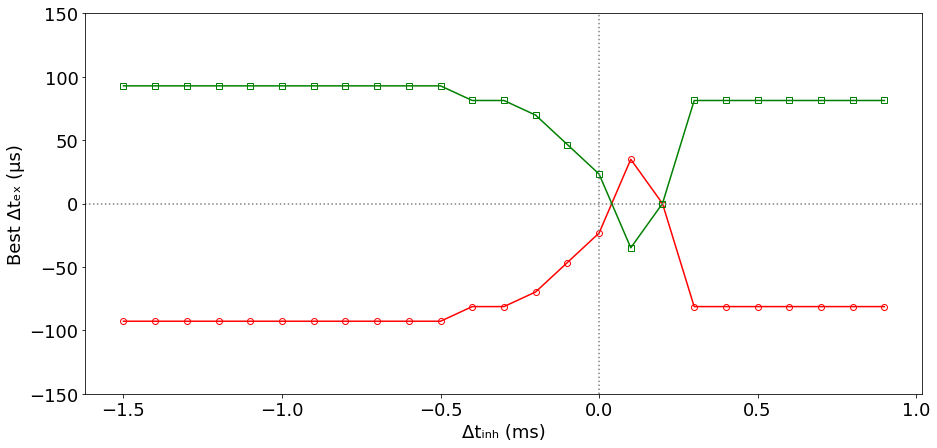

In [172]:
fig, ax = plt.subplots(1, figsize=(15,7))
    
ax.plot(delta_inh_array, best_contra[:,1],  marker='o', linestyle='-', color='red', markerfacecolor='none')
ax.plot(delta_inh_array, best_ipsi[:,1],  marker='s', linestyle='-', color='green', markerfacecolor='none')
ax.set_xlabel(unicodeit.replace('Δt_{inh} (ms)'))
ax.set_ylabel(unicodeit.replace('Best Δt_{ex} (μs)'))
ax.set_ylim([-150,150])
ax.axvline(0, linestyle = linestyles[0], color = 'grey')
ax.axhline(0, linestyle = linestyles[0], color = 'grey')

#for i in range(len(peak_shift_array)):
    #print(np.round(delta_inh_array[i],2), 'ms', np.round(peak_shift_array[i],2), 'us\n')

# Dependance on Vm

Peak Shifts:  [0 0 0 0 0 9 9 9 9 9] us


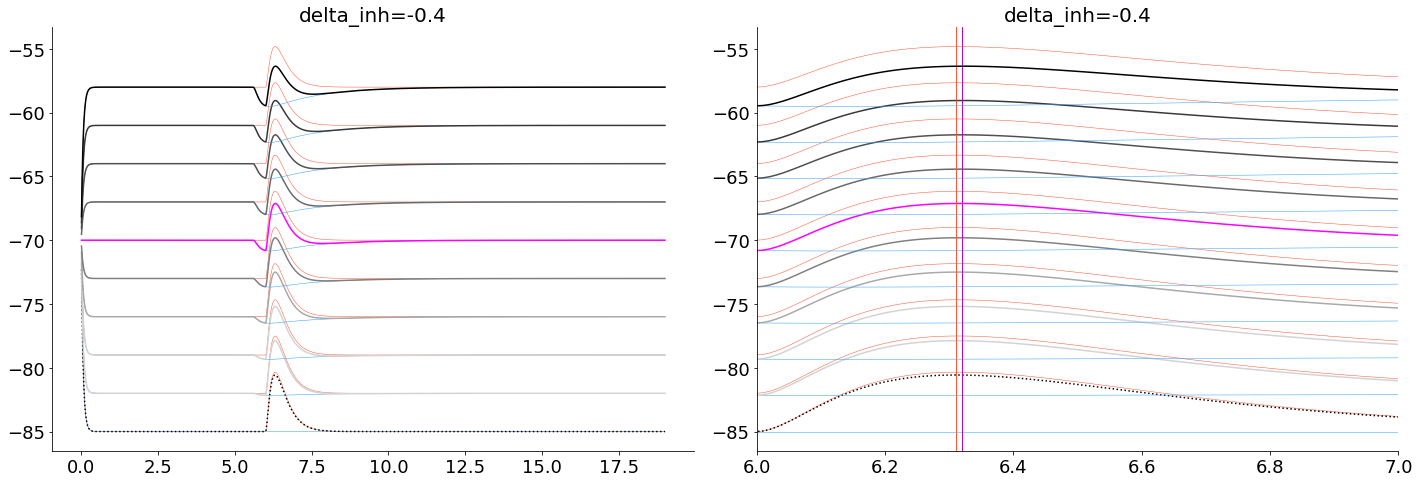

In [72]:
tone = 20
time_sim = 20
lim = time_sim
delta_inh = -0.4

taus = np.zeros(4)
taus[:] =  [0.2, 0.2, 0.3, 1.5] #default: [0.2, 2, 0.2, 2] #avgMyoga[x,x,0.3,1.5]  #bestMyoga[x,x,0.5,1]
w_ratio = 1

c_mso = 1
we = 1
wi = -we*w_ratio
delays_mso = [5,5+delta_inh] #ms
weights_mso = [we,wi]
v_th = -40
currents = np.arange(-250,250,50)
v_hyp = np.zeros_like(currents)
peak_shift = np.zeros_like(currents)

fig, ax = plt.subplots(1,2, figsize=(20,7))

for j in range(len(currents)):
    
    nest.ResetKernel()
    nest.local_num_threads = 16
    nest.resolution = 0.01 

    ipsi_e = nest.Create("spike_generator", 1, params={"spike_times": np.around(np.arange(1, time_sim+1, 1000/tone),2)})

    mso = nest.Create('iaf_cond_beta', 3)

    for i in range(3):
        mso[i].set(V_th = v_th, C_m = c_mso, tau_rise_ex = taus[0], tau_rise_in = taus[1], tau_decay_ex = taus[2], tau_decay_in = taus[3], I_e = currents[j])

    s = nest.Create('spike_recorder')

    m = nest.Create('multimeter', 1, {"record_from": ['V_m']})
    nest.SetStatus(m, {'interval': 0.01})

    nest.Connect(mso, s, 'all_to_all')
    nest.Connect(ipsi_e, s, 'one_to_one')

    nest.Connect(m, mso, 'all_to_all')

    nest.Connect(ipsi_e, mso[0], 'one_to_one', syn_spec = {"weight":weights_mso[0], "delay": delays_mso[0]})
    nest.Connect(ipsi_e, mso[1], 'one_to_one', syn_spec = {"weight":weights_mso[1], "delay": delays_mso[1]})
    nest.Connect(ipsi_e, mso[2], 'one_to_one', syn_spec = {"weight":weights_mso[0], "delay": delays_mso[0]})
    nest.Connect(ipsi_e, mso[2], 'one_to_one', syn_spec = {"weight":weights_mso[1], "delay": delays_mso[1]})

    nest.Simulate(time_sim)
    #data = s.get('events')
    pot = m.get('events')
    v_hyp[j] = np.round(pot['V_m'][np.where(pot['senders'] == mso[2])][np.where(pot['times'][np.where(pot['senders'] == mso[2])] == 2.5)][0],2)
    
    colors = ['black', 'lightgrey', '#d3d3d3', '#a9a9a9', '#808080', 'magenta', '#696969', '#505050', '#383838', 'black']
    linestyles = ['dotted'] + ['solid'] * 9  # First line is dotted, others are solid

    ax[1].set_xlim([6,7])
    t_both = pot['times'][max(range(len(pot['V_m'][np.where(pot['senders'] == mso[2])])), key=pot['V_m'][np.where(pot['senders'] == mso[2])].__getitem__)]
    t_exc = pot['times'][max(range(len(pot['V_m'][np.where(pot['senders'] == mso[0])])), key=pot['V_m'][np.where(pot['senders'] == mso[0])].__getitem__)]
    ax[1].axvline(t_both, color = col[2], linewidth = 0.5)
    ax[1].axvline(t_exc, color = col[0], linewidth = 0.5)
    peak_shift[j] = (t_both - t_exc)*1000
    peak_shift[j] = round(peak_shift[j],4)
    

    for i in range(2):      
        ax[i].set_title(f'{delta_inh=}')
        ax[i].plot(pot['times'][np.where(pot['senders'] == mso[0].get('global_id'))], pot['V_m'][np.where(pot['senders'] == mso[0].get('global_id'))], color = col[0], linewidth = 0.5)
        ax[i].plot(pot['times'][np.where(pot['senders'] == mso[1].get('global_id'))], pot['V_m'][np.where(pot['senders'] == mso[1].get('global_id'))], color = col[1], linewidth = 0.5)
        ax[i].plot(pot['times'][np.where(pot['senders'] == mso[2].get('global_id'))], pot['V_m'][np.where(pot['senders'] == mso[2].get('global_id'))], color = colors[j], linestyle = linestyles[j])
        ax[i].spines['top'].set_visible(False) 
        ax[i].spines['right'].set_visible(False)
        
print('Peak Shifts: ', peak_shift, 'us')
fig.tight_layout()

Text(0.5, 1.0, 'E-I ratio: 2:1')

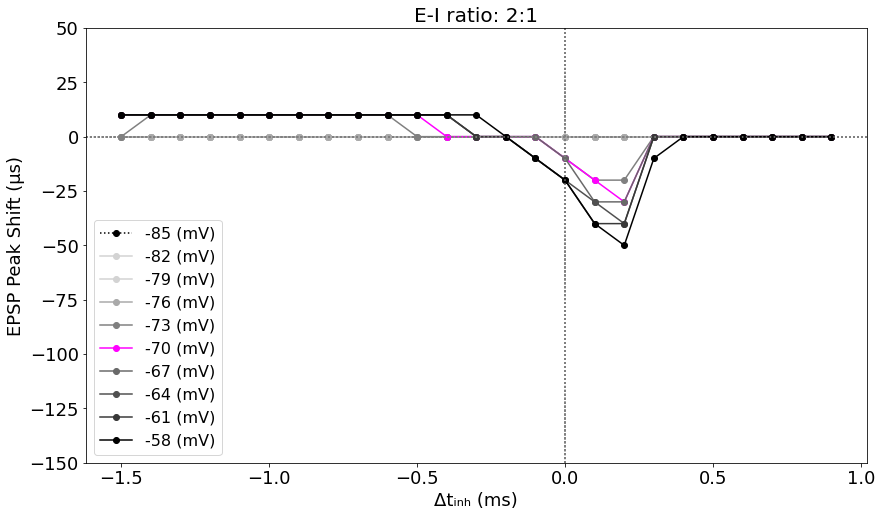

In [73]:
delta_inh_array = np.arange(-1.5,1,0.1)
peak_shift_array = np.zeros((len(currents), len(delta_inh_array)))

w_ratio = 1/2

for j in range(len(currents)):
    for i in range(len(delta_inh_array)):
        delta_inh = delta_inh_array[i]
        peak_shift_array[j,i] = simulate_mso(delta_inh, taus, w_ratio, currents[j], tone, time_sim)
        
fig, ax = plt.subplots(1, figsize=(14,8))
colors = ['black', 'lightgrey', '#d3d3d3', '#a9a9a9', '#808080', 'magenta', '#696969', '#505050', '#383838', 'black']
linestyles = ['dotted'] + ['solid'] * 9  # First line is dotted, others are solid

for j in range(len(currents)):
    ax.plot(delta_inh_array, peak_shift_array[j], 'o', color = colors[j], linestyle = linestyles[j], label = '{} (mV)'.format(v_hyp[j]))
    ax.set_xlabel(unicodeit.replace('Δt_{inh} (ms)'))
    ax.set_ylabel("EPSP Peak Shift (μs)")
    ax.set_ylim([-150,50])
    ax.axvline(0, linestyle = linestyles[0], color = 'grey')
    ax.axhline(0, linestyle = linestyles[0], color = 'grey')
#print(f"{w_ratio=}")
ax.legend(loc = 'lower left')
ax.set_title('E-I ratio: {}:1'.format(int(1/w_ratio)))

w_ratio=1


Text(0.5, 1.0, 'E-I ratio: 1:1')

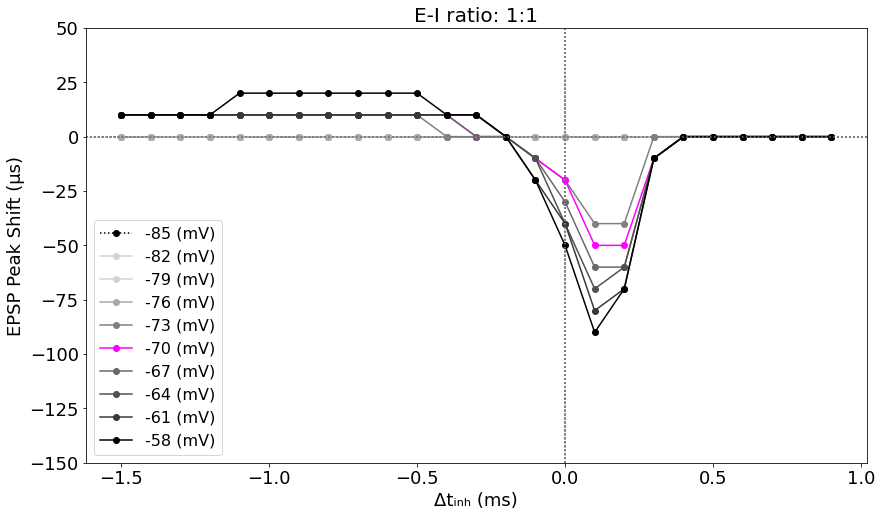

In [68]:
fig, ax = plt.subplots(1, figsize=(14,8))
colors = ['black', 'lightgrey', '#d3d3d3', '#a9a9a9', '#808080', 'magenta', '#696969', '#505050', '#383838', 'black']
linestyles = ['dotted'] + ['solid'] * 9  # First line is dotted, others are solid

for j in range(len(currents)):
    ax.plot(delta_inh_array, peak_shift_array[j], 'o', color = colors[j], linestyle = linestyles[j], label = '{} (mV)'.format(v_hyp[j]))
    ax.set_xlabel(unicodeit.replace('Δt_{inh} (ms)'))
    ax.set_ylabel("EPSP Peak Shift (μs)")
    ax.set_ylim([-150,50])
    ax.axvline(0, linestyle = linestyles[0], color = 'grey')
    ax.axhline(0, linestyle = linestyles[0], color = 'grey')
print(f"{w_ratio=}")
ax.legend(loc = 'lower left')
ax.set_title('E-I ratio: {}:1'.format(int(1/w_ratio)))